# Introduction

This notebook tackles the [**Playground Series – Season 5, Episode 10: Predicting Road Accident Risk**](https://www.kaggle.com/competitions/playground-series-s5e10), a competition focused on a critical real-world problem: predicting the likelihood of road accidents. The goal is to develop a regression model that can accurately estimate accident\_risk based on a variety of road conditions, environmental factors, and historical data.

### Our Approach

To achieve this, we will follow a structured machine learning workflow:

1.  **Exploratory Data Analysis (EDA):** We will begin by conducting a deep dive into the dataset to understand its structure, identify patterns, and uncover relationships between features and the target variable. This includes analyzing feature distributions, correlations, and data quality.
    
2.  **Data Preprocessing & Feature Engineering:** Based on insights from the EDA, we will clean the data (e.g., handle duplicates) and engineer new features to enhance the predictive power of our model. This will involve encoding categorical variables and creating interaction terms.
    
3.  **Model Development:** We will build and train a robust predictive model. Given the tabular nature of the data, we will likely focus on gradient boosting models like LightGBM or XGBoost, which are known for their high performance in similar competitions.
    
4.  **Submission:** Finally, we will use our trained model to make predictions on the test set and generate a submission.csv file in the required format.
    

### Initial Findings from EDA

Our preliminary analysis has already revealed several key characteristics of the dataset:

*   **High-Quality Data:** The training and test sets are well-structured and contain **no missing values**, which simplifies the preprocessing stage.
    
*   **Consistent Distributions:** The feature distributions between the training and test sets are remarkably similar, suggesting that a model trained on this data should generalize well.
    
*   **Key Predictors:** curvature and speed\_limit have emerged as the features with the strongest positive correlation to accident\_risk.
    
*   **Potential Data Leakage:** The num\_reported\_accidents feature shows a correlation with the target and will be handled with care to avoid data leakage.
    

Let's begin by loading the necessary libraries and exploring the data.

# Table of Contents

1. [Introduction](#Introduction)  
2. [Data Loading and Overview](#Data-Loading-and-Overview)
3. [Data Visualization](#Data-Visualization)
4. [Training Dataset EDA](#Training-Dataset-EDA)
5. [Test Dataset EDA](#Test-Dataset-EDA)
6. [Examine Original Dataset](#Examine-Original-Dataset)
7. [Original Dataset EDA](#Original-Dataset-EDA)
8. [Dataset Comparison Report](#Dataset-Comparison-Report)
9. [Feature Engineering](#Feature-Engineering)
10. [Model Training](#Model-Training)
11. [Prepare Submission](#Prepare-Submission)

# Data Loading and Overview

In [1]:
%pip install --no-binary lightgbm --config-settings=cmake.define.USE_CUDA=ON lightgbm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip -q install -U optuna
%pip -q install optuna-integration[lightgbm]


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# --- Standard library
import os
import sys
import random
import warnings
from pathlib import Path
from contextlib import contextmanager
from time import time
from typing import Iterable
from IPython.display import display, Markdown

# --- Third-party
import numpy as np
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice,
    plot_edf,
)
import scipy.stats as st
from scipy.stats import uniform, randint, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pandas.api.types import (
    is_categorical_dtype,
    is_numeric_dtype,
    is_object_dtype,
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score, RandomizedSearchCV
from sklearn import set_config
set_config(transform_output="pandas")
from statsmodels.graphics.gofplots import qqplot
from tqdm import tqdm
import lightgbm as lgbm
import xgboost as xgb

# --- Notebook settings
warnings.filterwarnings("ignore")

# Suppress XGBoost warnings about mismatched devices and tree methods.
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost.core')

%matplotlib inline

In [4]:
# Define some utilities functions
def configure_notebook(seed: int = 10301, float_precision: int = 3, max_columns: int = 15, max_rows: int = 25) -> int:
    """
    Configure notebook settings:
      - Disables warnings for cleaner output.
      - Sets pandas display options for better table formatting.
      - Returns a seed value for reproducibility.
    
    Parameters:
      seed (int): Random seed (default 548).
      float_precision (int): Number of decimal places for floats (default 3).
      max_columns (int): Maximum number of columns to display (default 15).
      max_rows (int): Maximum number of rows to display (default 25).

    Returns:
      int: The provided seed.
    """
    # Disable all warnings
    warnings.filterwarnings("ignore")
    
    # Set pandas display options for nicer output
    pd.options.display.float_format = f"{{:,.{float_precision}f}}".format
    pd.set_option("display.max_columns", max_columns)
    pd.set_option("display.max_rows", max_rows)

    # Set seeds for reproducibility in numpy and the standard random module
    np.random.seed(seed)
    random.seed(seed)
    
    return seed

def running_in_kaggle() -> bool:
    """
    Heuristics that are true in Kaggle notebooks:
    - Special directories exist (/kaggle/input, /kaggle/working)
    - Env var KAGGLE_KERNEL_RUN_TYPE is set
    - The kaggle_secrets module is available
    """
    try:
        if os.path.isdir("/kaggle/input") and os.path.isdir("/kaggle/working"):
            return True
        if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
            return True
        import kaggle_secrets  # noqa: F401  (only exists in Kaggle)
        return True
    except Exception:
        return False

# Use a context manager to suppress standard error output
# This is a robust way to handle warnings that bypass Python's warnings module
class SuppressStderr:
    def __enter__(self):
        self.original_stderr = sys.stderr
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stderr.close()
        sys.stderr = self.original_stderr

In [5]:
# Apply configuration and set random seeds for reproducibility
seed = configure_notebook()    

In [6]:
# Configurable flag to control whether GPU is used
USE_GPU = True

def resolve_lgbm_device(use_gpu: bool, X: pd.DataFrame, y: pd.Series,
                        platform_id: int = -1, device_id: int = -1):
    """
    Returns a dict of LightGBM params for the chosen device.
    Tries OpenCL GPU -> CPU.
    """
    if not use_gpu:
        return {"device_type": "cpu", "force_col_wise": True}  # CPU-only hint

    try:
        probe = lgbm.LGBMRegressor(
            n_estimators=10,
            device_type="gpu",
            max_bin=63,
            gpu_platform_id=platform_id, 
            gpu_device_id=device_id,
            verbosity=-1,
        )
        # tiny probe fit to validate the backend works
        _n = min(len(X), 2000)
        probe.fit(X.iloc[:_n], y.iloc[:_n])
        return {"device_type": "gpu", "gpu_platform_id": platform_id, "gpu_device_id": device_id}
    except Exception as e:
        print("OpenCL not available, falling back to CPU:", type(e).__name__, e)

    # Fall back to CPU
    return {"device_type": "cpu", "force_col_wise": True}

In [7]:
def eda_summary(df: pd.DataFrame) -> None:
    """
    Produce a concise, notebook-friendly Exploratory Data Analysis (EDA) summary.

    This utility prints and displays a standard set of diagnostics for a single
    DataFrame to help you quickly understand schema, completeness, and basic
    statistics. It is designed for use in Jupyter/IPython environments.

    The report includes:
      1. **First 5 rows** (transposed for vertical readability).
      2. **DataFrame info** (`df.info()`): dtypes and non-null counts.
      3. **Numeric describe** (`df.describe()`): count/mean/std/min/percentiles/max.
      4. **Categorical describe** (`df.select_dtypes(['object','category']).describe()`),
         or a note if none exist.
      5. **Missing values summary**: a table with per-column missing count and
         percentage of total rows.
      6. **Duplicate rows**: total number of duplicated records (`df.duplicated().sum()`).
      7. **Data types count**: frequency of each dtype in `df.dtypes`.
      8. **Correlation matrix** for numeric columns (if more than one numeric
         column exists), computed with Pearson correlation.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to summarize.

    Returns
    -------
    None
        Displays/prints the EDA sections and returns nothing.
    """
    # 1. Display the first few rows
    print("======== First 5 Rows ========")
    display(df.head().T)
    
    # 2. DataFrame information (data types, non-null counts, etc.)
    print("\n======== DataFrame Info ========")
    df.info()
    
    # 3. Descriptive statistics for numeric columns
    print("\n======== Descriptive Statistics (Numeric Columns) ========")
    display(df.describe().T)
    
    # 4. Descriptive statistics for categorical columns (if any)
    categorical_df = df.select_dtypes(include=['object', 'category'])
    print("\n======== Descriptive Statistics (Categorical Columns) ========")
    if not categorical_df.empty:
        display(categorical_df.describe())
    else:
        print("No categorical columns found.")
    
    # 5. Missing values summary
    print("\n======== Missing Values Summary ========")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_summary = pd.DataFrame({
        "Missing Count": missing,
        "Percentage": missing_percent
    })
    display(missing_summary)
    
    # 6. Count of duplicated rows
    print("\n======== Duplicated Rows ========")
    print(f"Total duplicated rows: {df.duplicated().sum()}")
    
    # 7. Count of each data type
    print("\n======== Data Types Count ========")
    display(df.dtypes.value_counts())
    
    # 8. Correlation matrix for numeric variables (if more than one exists)
    numeric_cols = df.select_dtypes(include=[np.number])
    if numeric_cols.shape[1] > 1:
        print("\n======== Correlation Matrix (Numeric Columns) ========")
        display(numeric_cols.corr())
    else:
        print("\n======== Correlation Matrix ========")
        print("Not enough numeric columns to compute correlation.")
    
    # 9. Value counts for categorical variables with low cardinality
    print("\n======== Value Counts for Categorical Columns (Low Cardinality) ========")
    if not categorical_df.empty:
        for col in categorical_df.columns:
            if df[col].nunique() <= 20:
                print(f"\nValue Counts for '{col}':")
                display(df[col].value_counts())
    else:
        print("No categorical columns found.")


#### Read the training data and display a bit of it

In [8]:
DATA_DIR = Path('/kaggle/input/playground-series-s5e10') if running_in_kaggle() else Path('data')

training_df = pd.read_csv(DATA_DIR / 'train.csv')
training_df.head()

id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   0     urban          2      0.060           35  daylight   rainy   
1   1     urban          4      0.990           35  daylight   clear   
2   2     rural          4      0.630           70       dim   clear   
3   3   highway          4      0.070           35       dim   rainy   
4   4     rural          1      0.580           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk  
0                       1          0.130  
1                       0          0.350  
2                       2          0.300  
3                       1          0.210  
4                       1          0.560

#### Read the test data and display it

In [9]:
test_df = pd.read_csv(DATA_DIR / 'test.csv')
test_df.head()

id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0  517754   highway          2      0.340           45     night   clear   
1  517755     urban          3      0.040           45       dim   foggy   
2  517756     urban          2      0.590           35       dim   clear   
3  517757     rural          4      0.950           35  daylight   rainy   
4  517758   highway          2      0.860           35  daylight   clear   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0                True         True   afternoon     True           True   
1                True        False   afternoon     True          False   
2                True        False   afternoon     True           True   
3               False        False   afternoon    False          False   
4                True        False     evening    False           True   

   num_reported_accidents  
0                       1  
1                       0  
2                       1  
3                       2  
4                       3

#### Get rid of the 'id' column before examining the data.  Also, it'll confuse training.

In [10]:
training_df.drop('id', axis=1, inplace=True)
training_df.head()

road_type  num_lanes  curvature  speed_limit  lighting weather  \
0     urban          2      0.060           35  daylight   rainy   
1     urban          4      0.990           35  daylight   clear   
2     rural          4      0.630           70       dim   clear   
3   highway          4      0.070           35       dim   rainy   
4     rural          1      0.580           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk  
0                       1          0.130  
1                       0          0.350  
2                       2          0.300  
3                       1          0.210  
4                       1          0.560

In [11]:
# Save a copy with the ID for use later
test_ids = test_df['id'].copy()

test_df.drop('id', axis=1, inplace=True)
test_df.head()

road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   highway          2      0.340           45     night   clear   
1     urban          3      0.040           45       dim   foggy   
2     urban          2      0.590           35       dim   clear   
3     rural          4      0.950           35  daylight   rainy   
4   highway          2      0.860           35  daylight   clear   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0                True         True   afternoon     True           True   
1                True        False   afternoon     True          False   
2                True        False   afternoon     True           True   
3               False        False   afternoon    False          False   
4                True        False     evening    False           True   

   num_reported_accidents  
0                       1  
1                       0  
2                       1  
3                       2  
4                       3

## Exploratory Data Analysis

In [12]:
eda_summary(training_df)

======== First 5 Rows ========


0         1        2        3         4
road_type                   urban     urban    rural  highway     rural
num_lanes                       2         4        4        4         1
curvature                   0.060     0.990    0.630    0.070     0.580
speed_limit                    35        35       70       35        60
lighting                 daylight  daylight      dim      dim  daylight
weather                     rainy     clear    clear    rainy     foggy
road_signs_present          False      True    False     True     False
public_road                  True     False     True     True     False
time_of_day             afternoon   evening  morning  morning   evening
holiday                     False      True     True    False      True
school_season                True      True    False    False     False
num_reported_accidents          1         0        2        1         1
accident_risk               0.130     0.350    0.300    0.210     0.560


======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object

count   mean    std    min    25%    50%    75%  \
num_lanes              517,754.000  2.492  1.120  1.000  1.000  2.000  3.000   
curvature              517,754.000  0.489  0.273  0.000  0.260  0.510  0.710   
speed_limit            517,754.000 46.113 15.789 25.000 35.000 45.000 60.000   
num_reported_accidents 517,754.000  1.188  0.896  0.000  1.000  1.000  2.000   
accident_risk          517,754.000  0.352  0.166  0.000  0.230  0.340  0.460   

                          max  
num_lanes               4.000  
curvature               1.000  
speed_limit            70.000  
num_reported_accidents  7.000  
accident_risk           1.000


======== Descriptive Statistics (Categorical Columns) ========


road_type lighting weather time_of_day
count     517754   517754  517754      517754
unique         3        3       3           3
top      highway      dim   foggy     morning
freq      173672   183826  181463      173410


======== Missing Values Summary ========


Missing Count  Percentage
road_type                           0       0.000
num_lanes                           0       0.000
curvature                           0       0.000
speed_limit                         0       0.000
lighting                            0       0.000
weather                             0       0.000
road_signs_present                  0       0.000
public_road                         0       0.000
time_of_day                         0       0.000
holiday                             0       0.000
school_season                       0       0.000
num_reported_accidents              0       0.000
accident_risk                       0       0.000


======== Duplicated Rows ========
Total duplicated rows: 656

======== Data Types Count ========


object     4
bool       4
int64      3
float64    2
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


num_lanes  curvature  speed_limit  \
num_lanes                   1.000     -0.020        0.001   
curvature                  -0.020      1.000        0.008   
speed_limit                 0.001      0.008        1.000   
num_reported_accidents      0.018      0.145        0.031   
accident_risk              -0.006      0.544        0.431   

                        num_reported_accidents  accident_risk  
num_lanes                                0.018         -0.006  
curvature                                0.145          0.544  
speed_limit                              0.031          0.431  
num_reported_accidents                   1.000          0.214  
accident_risk                            0.214          1.000


======== Value Counts for Categorical Columns (Low Cardinality) ========

Value Counts for 'road_type':


road_type
highway    173672
rural      172719
urban      171363
Name: count, dtype: int64


Value Counts for 'lighting':


lighting
dim         183826
daylight    178015
night       155913
Name: count, dtype: int64


Value Counts for 'weather':


weather
foggy    181463
clear    179306
rainy    156985
Name: count, dtype: int64


Value Counts for 'time_of_day':


time_of_day
morning      173410
evening      172837
afternoon    171507
Name: count, dtype: int64

#### Show the statistics and structure of the test data

In [13]:
eda_summary(test_df)

======== First 5 Rows ========


0          1          2          3         4
road_type                 highway      urban      urban      rural   highway
num_lanes                       2          3          2          4         2
curvature                   0.340      0.040      0.590      0.950     0.860
speed_limit                    45         45         35         35        35
lighting                    night        dim        dim   daylight  daylight
weather                     clear      foggy      clear      rainy     clear
road_signs_present           True       True       True      False      True
public_road                  True      False      False      False     False
time_of_day             afternoon  afternoon  afternoon  afternoon   evening
holiday                      True       True       True      False     False
school_season                True      False       True      False      True
num_reported_accidents          1          0          1          2         3


======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               172585 non-null  object 
 1   num_lanes               172585 non-null  int64  
 2   curvature               172585 non-null  float64
 3   speed_limit             172585 non-null  int64  
 4   lighting                172585 non-null  object 
 5   weather                 172585 non-null  object 
 6   road_signs_present      172585 non-null  bool   
 7   public_road             172585 non-null  bool   
 8   time_of_day             172585 non-null  object 
 9   holiday                 172585 non-null  bool   
 10  school_season           172585 non-null  bool   
 11  num_reported_accidents  172585 non-null  int64  
dtypes: bool(4), float64(1), int64(3), object(4)
memory usage: 11.2+ MB

======== Descriptive Stati

count   mean    std    min    25%    50%    75%  \
num_lanes              172,585.000  2.494  1.119  1.000  1.000  2.000  3.000   
curvature              172,585.000  0.487  0.272  0.000  0.260  0.510  0.710   
speed_limit            172,585.000 46.103 15.787 25.000 35.000 45.000 60.000   
num_reported_accidents 172,585.000  1.186  0.897  0.000  1.000  1.000  2.000   

                          max  
num_lanes               4.000  
curvature               1.000  
speed_limit            70.000  
num_reported_accidents  7.000


======== Descriptive Statistics (Categorical Columns) ========


road_type lighting weather time_of_day
count     172585   172585  172585      172585
unique         3        3       3           3
top      highway      dim   foggy     morning
freq       58080    61143   60236       57747


======== Missing Values Summary ========


Missing Count  Percentage
road_type                           0       0.000
num_lanes                           0       0.000
curvature                           0       0.000
speed_limit                         0       0.000
lighting                            0       0.000
weather                             0       0.000
road_signs_present                  0       0.000
public_road                         0       0.000
time_of_day                         0       0.000
holiday                             0       0.000
school_season                       0       0.000
num_reported_accidents              0       0.000


======== Duplicated Rows ========
Total duplicated rows: 1203

======== Data Types Count ========


object     4
bool       4
int64      3
float64    1
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


num_lanes  curvature  speed_limit  \
num_lanes                   1.000     -0.021        0.002   
curvature                  -0.021      1.000        0.006   
speed_limit                 0.002      0.006        1.000   
num_reported_accidents      0.017      0.143        0.030   

                        num_reported_accidents  
num_lanes                                0.017  
curvature                                0.143  
speed_limit                              0.030  
num_reported_accidents                   1.000


======== Value Counts for Categorical Columns (Low Cardinality) ========

Value Counts for 'road_type':


road_type
highway    58080
rural      57409
urban      57096
Name: count, dtype: int64


Value Counts for 'lighting':


lighting
dim         61143
daylight    59397
night       52045
Name: count, dtype: int64


Value Counts for 'weather':


weather
foggy    60236
clear    59982
rainy    52367
Name: count, dtype: int64


Value Counts for 'time_of_day':


time_of_day
morning      57747
evening      57629
afternoon    57209
Name: count, dtype: int64

# Data Visualization

#### Target & Feature distributions — What & why
We first examine the distribution of **accident_risk** and the marginal distributions of key numeric features.
This reveals central tendency, spread, skewness, and potential multi‑modality (e.g., half/double‑time clusters).
These insights inform scaling and simple transforms and guard against outlier‑driven RMSE errors.

In [14]:
TARGET = "accident_risk"
IS_CLASSIFICATION = training_df[TARGET].nunique() <= 10 and training_df[TARGET].dtype != float

In [15]:
def split_columns(df: pd.DataFrame, max_cardinality: int = 30):
    """
    Heuristic split into numeric vs categorical, with a cardinality cap for cats.
    """
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in df.columns if c not in num_cols]
    
    # treat low-unique integer columns as categorical (IDs will be filtered later)
    for c in list(num_cols):
        if pd.api.types.is_integer_dtype(df[c]) and df[c].nunique(dropna=True) <= max_cardinality:
            cat_cols.append(c)
            num_cols.remove(c)
            
    # drop high-cardinality cats from categorical plotting by default
    low_card_cats = [c for c in cat_cols if df[c].nunique(dropna=True) <= max_cardinality]
    
    return num_cols, low_card_cats
    
# short axis label helper
def colname(v):
    return str(v).replace("_", " ").title()

In [16]:
def plot_missingness(df: pd.DataFrame):
    miss = df.isna().mean().sort_values(ascending=False)
    miss = miss[miss > 0]
    if miss.empty:
        print("No missing values.")
        return
        
    plt.figure(figsize = (8, max(2, 0.3 * len(miss))))
    plt.barh(miss.index, miss.values)
    plt.xlabel("Fraction Missing")
    plt.title("Missingness by Column")
    plt.gca().invert_yaxis()
    plt.show()
    
    display(miss.to_frame("missing_frac"))

In [17]:
def plot_numeric_univariate(df: pd.DataFrame, cols: Iterable[str], kde: bool = True):
    for c in cols:
        x = df[c].dropna().to_numpy()
        if x.size == 0:
            continue

        # ECDF (robust view of distribution)
        xs = np.sort(x)
        ys = np.arange(1, xs.size + 1) / xs.size
        plt.figure(figsize=(7, 4))
        plt.plot(xs, ys)
        plt.xlabel(colname(c)); plt.ylabel("ECDF")
        plt.title(f"{c} – Empirical CDF")
        plt.show()

        # Smooth density (KDE) if supported and enough data
        if kde and xs.size >= 50:
            try:
                from scipy.stats import gaussian_kde
                grid = np.linspace(xs.min(), xs.max(), 256)
                dens = gaussian_kde(xs)(grid)
                plt.figure(figsize=(7, 4))
                plt.plot(grid, dens)
                plt.xlabel(colname(c)); plt.ylabel("Density")
                plt.title(f"{c} – Density (KDE)")
                plt.show()
            except Exception as e:
                # skip quietly if scipy not available
                pass

In [18]:
def plot_categorical_univariate(df: pd.DataFrame, cols: Iterable[str], top_n = 20, normalize = False):
    for c in cols:
        vc = df[c].astype("object").value_counts(dropna=False)
        if vc.empty:
            continue
            
        vc = vc.head(top_n)
        plt.figure(figsize=(8, max(2, 0.35 * len(vc))))
        plt.barh(vc.index.astype(str), vc.values if not normalize else (vc.values / vc.sum()))
        plt.gca().invert_yaxis()
        plt.xlabel("Count" if not normalize else "Proportion")
        plt.title(f"{c} – Top {len(vc)} Categories")
        plt.show()

In [19]:
def collapse_rare_categories(s: pd.Series, min_count: int = 50) -> pd.Series:
    vc = s.value_counts()
    keep = vc[vc >= min_count].index
    return s.where(s.isin(keep), other="__OTHER__")

In [20]:
def categorical_vs_target_classification(df: pd.DataFrame, feature, target, min_count = 50, top_n = 20):
    s = collapse_rare_categories(df[feature].astype("object"), min_count=min_count)
    d = pd.DataFrame({feature: s, target: df[target]}).dropna()
    grp = d.groupby(feature)
    counts = grp.size().sort_values(ascending=False).head(top_n)
    cats = counts.index

    rate = grp[target].mean().reindex(cats)

    # counts
    plt.figure(figsize=(8, max(2, 0.35 * len(cats))))
    plt.barh([str(c) for c in cats], counts.values)
    plt.gca().invert_yaxis()
    plt.xlabel("Count"); plt.title(f"{feature} – Top {len(cats)} Counts")
    plt.show()

    # target rates
    plt.figure(figsize=(8, max(2, 0.35 * len(cats))))
    plt.barh([str(c) for c in cats], rate.values)
    plt.gca().invert_yaxis()
    plt.xlabel(f"Mean {target}"); plt.title(f"{feature} – Target Rate (Top {len(cats)})")
    plt.show()

In [21]:
def numeric_vs_target_regression(df: pd.DataFrame, feature:str, target:str = TARGET, n_bins:int = 20):
    # guardrails
    s = df[feature]
    if pd.api.types.is_bool_dtype(s) or s.nunique(dropna = True) < 2:
        return  # treat bools as categorical elsewhere; skip constants

    d = df[[feature, target]].dropna()
    if d.empty:
        return

    # Use quantile bins unless the feature has very few unique values
    if d[feature].nunique() <= n_bins:
        # group by the actual values (e.g., speed_limit with few discrete values)
        gb = d.groupby(feature, sort = True)[target]
        centers = gb.mean().index.to_numpy(dtype = float)  # numeric categories
    else:
        q = pd.qcut(
            d[feature],
            q=min(n_bins, d[feature].nunique()),
            duplicates="drop"
        )
        gb = d.groupby(q, observed=True)[target]
        idx = gb.mean().index  # IntervalIndex
        # bin centers
        centers = getattr(idx, "mid", np.array([(iv.left + iv.right) / 2.0 for iv in idx]))

    means = gb.mean().to_numpy()
    stds  = gb.std(ddof = 0).to_numpy()

    # mean line
    plt.figure(figsize = (7, 4))
    plt.plot(centers, means)
    plt.xlabel(colname(feature)); 
    plt.ylabel(f"Mean {target}")
    plt.title(f"{feature} – Mean {target} by Bin")
    plt.show()

    # std line
    plt.figure(figsize = (7, 4))
    plt.plot(centers, stds)
    plt.xlabel(colname(feature)); 
    plt.ylabel(f"Std({target})")
    plt.title(f"{feature} – Target Std by Bin")
    plt.show()

In [22]:
def categorical_vs_target_regression(df: pd.DataFrame, feature:str, target:str = TARGET, min_count:int = 50, top_n:int = 20):
    s = collapse_rare_categories(df[feature].astype("object"), min_count = min_count)
    d = pd.DataFrame({feature: s, target: df[target]}).dropna()
    stats = d.groupby(feature)[target].agg(["count", "mean"]).sort_values("count", ascending = False).head(top_n)

    plt.figure(figsize=(8, max(2, 0.35 * len(stats))))
    plt.barh(stats.index.astype(str), stats["mean"].values)
    plt.gca().invert_yaxis()
    plt.xlabel(f"Mean {target}")
    plt.title(f"{feature} – Mean {target} (Top {len(stats)})")
    plt.show()

    plt.figure(figsize=(8, max(2, 0.35 * len(stats))))
    plt.barh(stats.index.astype(str), stats["count"].values)
    plt.gca().invert_yaxis()
    plt.xlabel("Count")
    plt.title(f"{feature} – Count (Top {len(stats)})")
    plt.show()

In [23]:
def cramers_v(x: pd.Series, y: pd.Series) -> float:
    tbl = pd.crosstab(x, y)
    chi2 = chi2_contingency(tbl, correction = False)[0]
    n = tbl.values.sum()
    r, k = tbl.shape
    v = np.sqrt(chi2 / (n * (min(r, k) - 1)))
    return float(v)

def categorical_associations(df: pd.DataFrame, cats: Iterable[str]):
    cats = [c for c in cats if df[c].notna().any()]
    out = pd.DataFrame(index = cats, columns = cats, dtype = float)
    for i, c1 in enumerate(cats):
        for c2 in cats[i:]:
            v = cramers_v(df[c1].astype("object"), df[c2].astype("object"))
            out.loc[c1, c2] = out.loc[c2, c1] = v
    return out

In [24]:
def has_target(df: pd.DataFrame, target:str):
    return target is not None and target in df.columns

In [25]:
def check_leakage(df: pd.DataFrame, target:str = TARGET):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    # Target bounds and mass at the edges
    t = df["accident_risk"].dropna().to_numpy()
    print(f"min={t.min():.4f}, max={t.max():.4f}")
    print(f"mass at 0: {(t==0).mean():.3%}, mass at 1: {(t==1).mean():.3%}")

    # Simple leakage probe (e.g., counts that trivially drive risk)
    suspects = ["num_reported_accidents"]
    for c in suspects:
        if c in df.columns:
            s = df[[c, "accident_risk"]].dropna()
            rho = s[c].corr(s["accident_risk"])
            print(f"{c}: Pearson r = {rho:.3f} (check this column carefully)")

In [26]:
def plot_target_by_category(df: pd.DataFrame, cat:str, target:str = TARGET, top_n:int = 20, min_count:int = 100):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return

    d = df[[cat, target]].dropna()
    vc = d[cat].astype("object").value_counts()
    keep = vc[vc >= min_count].head(top_n).index
    d = d[d[cat].isin(keep)]
    g = d.groupby(cat)[target].agg(["count","mean","std"])
    se = g["std"] / (g["count"].clip(lower = 1) ** 0.5)  # standard error

    # mean line with error bars (horizontal layout)
    plt.figure(figsize=(8, max(2, 0.35 * len(g))))
    idx = g.index.astype(str)
    plt.errorbar(g["mean"].values, np.arange(len(g)), xerr = 1.96 * se.values, fmt = "o")
    plt.yticks(np.arange(len(g)), idx)
    plt.xlabel(f"Mean {target} (±95% CI)")
    plt.title(f"{cat} → {target}")
    plt.gca().invert_yaxis()
    plt.show()

In [27]:
def binned_mean_std(df: pd.DataFrame, xcol:str, target:str = TARGET, q:int = 20):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    d = df[[xcol, target]].dropna().sort_values(xcol)

    # skip booleans or constant columns
    if pd.api.types.is_bool_dtype(d[xcol]) or d[xcol].nunique() < 2:
        return
        
    # quantile bins
    bins = pd.qcut(d[xcol], q=min(q, d[xcol].nunique()), duplicates = "drop")
    g = d.groupby(bins)[target].agg(["mean", "std", "count"])
    
    idx = g.index  # IntervalIndex
    try:
        centers = idx.mid.to_numpy()
    except AttributeError:
        # fallback for very old pandas
        centers = np.array([(iv.left + iv.right) * 0.5 for iv in idx])

    plt.figure(figsize=(7, 4))
    plt.plot(centers, g["mean"].values)
    plt.xlabel(xcol); 
    plt.ylabel(f"Mean {target}"); 
    plt.title(f"{xcol} → mean({target})")
    plt.show()
    
    plt.figure(figsize=(7, 4))
    plt.plot(centers, g["std"].values)
    plt.xlabel(xcol); 
    plt.ylabel(f"Std({target})"); 
    plt.title(f"{xcol} → std({target})")
    plt.show()

In [28]:
def numeric_by_category_trend(df: pd.DataFrame, xcol:str, cat:str, target:str = TARGET, q:int = 15, min_count:int = 2000):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    # Keep frequent categories to reduce noise
    keep = df[cat].value_counts()
    keep = keep[keep >= min_count].index
    for k in keep:
        d = df[df[cat] == k][[xcol, target]].dropna()
        if d.empty or d[xcol].nunique() <2 : 
            continue
            
        bins = pd.qcut(d[xcol], q = min(q, d[xcol].nunique()), duplicates = "drop")
        m = d.groupby(bins)[target].mean()

        idx = m.index
        try:
            centers = idx.mid.to_numphy()
        except AttributeError:
            # fallback for very old pandas
            centers = np.array([(iv.left + iv.right) * 0.5 for iv in idx])
            
    plt.plot(centers, m.values, label = str(k))
    plt.title(f"{xcol} → mean({target}) by {cat}")
    plt.xlabel(xcol); 
    plt.ylabel(f"Mean {target}")
    plt.legend(loc="best")
    plt.show()

In [29]:
def cat_cat_heatmap(df: pd.DataFrame, cat1:str, cat2:str, target:str = TARGET, min_count:int = 500):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    d = df[[cat1, cat2, target]].dropna()
    g = d.groupby([cat1, cat2])[target].agg(["mean", "count"]).reset_index()
    g = g[g["count"] >= min_count]
    if g.empty:
        print(f"[info] No {cat1}×{cat2} cells with count >= {min_count}.")
        return

    # Normalize labels ONCE to consistent strings
    s1 = g[cat1].astype("string").fillna("<NA>").astype(str)
    s2 = g[cat2].astype("string").fillna("<NA>").astype(str)

    # Stable ordering (by label) or by frequency if preferred
    rows, r_codes = np.unique(s1, return_inverse = True)
    cols, c_codes = np.unique(s2, return_inverse = True)

    A = np.full((len(rows), len(cols)), np.nan, dtype = float)
    A[r_codes, c_codes] = g["mean"].to_numpy()

    plt.figure(figsize=(1.2 * len(cols) + 2, 1.2 * len(rows) + 2))
    im = plt.imshow(A, aspect = "auto", origin = "upper")
    cbar = plt.colorbar(im, fraction = 0.046, pad = 0.04, label = f"Mean {target}")
    plt.xticks(np.arange(len(cols)), cols, rotation = 45, ha = "right")
    plt.yticks(np.arange(len(rows)), rows)
    plt.title(f"{cat1} × {cat2} → mean({target})")
    plt.tight_layout()
    plt.show()

In [30]:
def numeric_numeric_hex(df: pd.DataFrame, x:str, y:str, target:str = TARGET, gridsize:int = 50):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    d = df[[x, y, target]].dropna()
    plt.figure(figsize = (7, 5))
    hb = plt.hexbin(d[x].to_numpy(), d[y].to_numpy(), C=d[target].to_numpy(),
                    gridsize = gridsize, reduce_C_function = np.mean)
    plt.xlabel(x); plt.ylabel(y); plt.title(f"{x} × {y} → mean({target})")
    cb = plt.colorbar(hb)
    cb.set_label(f"Mean {target}")
    plt.show()

In [31]:
def time_of_day_vs_risk_line(df: pd.DataFrame, target:str = TARGET):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    # Time_of_day has discrete labels ("morning","afternoon","evening")
    order = ["morning", "afternoon", "evening"]
    d = df[["time_of_day","accident_risk"]].dropna()
    d = d[d["time_of_day"].isin(order)]
    g = d.groupby("time_of_day")["accident_risk"].mean().reindex(order)

    plt.figure(figsize=(7, 4))
    plt.plot(np.arange(len(g)), g.values)
    plt.xticks(np.arange(len(g)), g.index, rotation = 0)
    plt.xlabel("time_of_day"); 
    plt.ylabel("Mean accident_risk"); 
    plt.title("Daily pattern")
    
    plt.show()

In [32]:
# Feature signal ranking without modeling
def show_feature_signal_ranking(df: pd.DataFrame, target:str = TARGET):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    # Spearman for numeric; ANOVA-style effect for categoricals
    num_cols = df.select_dtypes(include = [np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != target]

    scores = []
    for c in num_cols:
        s = df[[c, target]].dropna()
        if s.empty: continue
        rho, p = st.spearmanr(s[c], s[target])
        scores.append((c, float(rho)))
    scores = sorted(scores, key = lambda x: -abs(x[1]))
    print("Top numeric (|Spearman|):", scores[:10])

    cat_cols = [c for c in df.columns if c not in num_cols + [target]]
    effects = []
    for c in cat_cols:
        g = df.groupby(c, observed = True)[target].mean()
        if g.size >= 2:
            rng = float(g.max() - g.min())
            effects.append((c, rng, int(df[c].nunique())))
            
    effects = sorted(effects, key = lambda x: -x[1])
    print("Top categorical (range of mean risk):", effects[:10])

In [33]:
def plot_pairplot(df: pd.DataFrame, num_features: Iterable[str], target:str = TARGET):
    """
    Generates a pair plot for numerical features, colored by the target variable.
    """
    sns.pairplot(df[num_features + [target]], hue=target, palette = 'viridis')
    plt.suptitle('Pair Plot of Numerical Features', y = 1.02)
    plt.show()

def plot_boxplots(df: pd.DataFrame, cat_features: Iterable[str], target:str = TARGET):
    """
    Generates box plots for each categorical feature against the target variable.
    """
    for feature in cat_features:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x = feature, y = target, data = df, palette = 'viridis')
        plt.title(f'Box Plot of {target} by {feature}')
        plt.xticks(rotation = 45)
        plt.show()

def plot_violinplots(df: pd.DataFrame, cat_features: Iterable[str], target:str = TARGET):
    """
    Generates violin plots for each categorical feature against the target variable.
    """
    for feature in cat_features:
        plt.figure(figsize=(10, 6))
        sns.violinplot(x=feature, y=target, data = df, palette = 'viridis')
        plt.title(f'Violin Plot of {target} by {feature}')
        plt.xticks(rotation = 45)
        plt.show()

In [34]:
def is_discrete_numeric(s: pd.Series, max_unique:int = 20):
    return pd.api.types.is_numeric_dtype(s) and s.nunique(dropna = True) <= max_unique

def top_numeric_by_spearman(df: pd.DataFrame, num_cols: Iterable[str], target, k = 6):
    import scipy.stats as st
    scores = []
    for c in num_cols:
        d = df[[c, target]].dropna()
        if d.empty: 
            continue
            
        # skip all-constant / all-equal
        if d[c].nunique() < 2: 
            continue
            
        rho, _ = st.spearmanr(d[c], d[target])
        if np.isfinite(rho):
            scores.append((c, abs(float(rho))))
            
    scores.sort(key=lambda x: -x[1])
    return [c for c,_ in scores[:k]]

def top_categorical_by_range(df: pd.DataFrame, cat_cols: Iterable[str], target:str = TARGET, min_count:int = 200, k:int = 6):
    effects = []
    for c in cat_cols:
        d = df[[c, target]].dropna()
        if d.empty: 
            continue
            
        vc = d[c].value_counts()
        keep = set(vc[vc >= min_count].index)
        if not keep:
            continue
            
        m = d[d[c].isin(keep)].groupby(c)[target].mean()
        if m.size >= 2:
            effects.append((c, float(m.max() - m.min())))
            
    effects.sort(key=lambda x: -x[1])
    return [c for c,_ in effects[:k]]

In [35]:
def run_eda(df: pd.DataFrame, target: str, max_cat_card: int = 30,
            heavy_sample: int = 150_000, num_count: int = 10, cat_count = 10):
    """
    Compact EDA runner for mixed tabular data.
    - Uses new target-aware visuals when target is present.
    - Skips safely on test sets (no target).
    - Limits heavy plots to top-signal features.
    - Optionally downsamples for hexbin/heatmaps.
    """
    # Separate a version without target (works if target absent)
    df_wo_target = df.drop(columns = [target], errors = "ignore") if target else df

    # Split columns
    num_cols, cat_cols = split_columns(df_wo_target, max_cardinality = max_cat_card)
    
    # Treat booleans as categorical for plotting
    bool_cols = [c for c in df_wo_target.columns if pd.api.types.is_bool_dtype(df_wo_target[c])]
    cat_cols = sorted(set(cat_cols).union(bool_cols))

    print(f"Columns → numeric: {len(num_cols)}, categorical≤{max_cat_card}: {len(cat_cols)}")

    # Leakage
    display(Markdown("### Leakage"))
    check_leakage(df, TARGET)

    # Missingness
    display(Markdown("### Missingness"))
    plot_missingness(df)

    # Univariate (target-agnostic)
    if num_cols:
        # ECDF + optional KDE
        display(Markdown("### Numeric Univariate"))
        plot_numeric_univariate(df_wo_target, num_cols, kde = True)
    if cat_cols:
        display(Markdown("### Categorical Univariate"))
        plot_categorical_univariate(df_wo_target, cat_cols, top_n = 20, normalize = False)

    # 2) Target-aware (only if target present)
    if not has_target(df, target):
        print("Target not present → skipping target-aware plots.")
        return

    y = df[target]
    is_regression = pd.api.types.is_numeric_dtype(y) and y.nunique(dropna = True) > 20

    # Choose top features to keep plots readable and fast
    if is_regression:
        top_nums = top_numeric_by_spearman(df, [c for c in num_cols if c != target], target, k = num_count) or num_cols[:num_count]
        top_cats = top_categorical_by_range(df, cat_cols, target, min_count = 200, k = cat_count) or cat_cols[:cat_count]

        # Numeric → target lines (discrete vs continuous)
        display(Markdown("### Numeric → Target Lines (Discrete vs Continuous)"))
        for c in top_nums:
            s = df[c]
            try:
                if is_discrete_numeric(s, max_unique = 20):
                    binned_mean_std_discrete(df, c, target = target)
                else:
                    binned_mean_std(df, c, target=target, q = 20)
            except Exception as e:
                print(f"[warn] numeric plot failed for {c}: {e}")

        # Categorical → target bars
        display(Markdown("### Categorical → Target Bars"))
        for c in top_cats:
            try:
                categorical_vs_target_regression(df, c, target = target, min_count = 100, top_n = 20)
            except Exception as e:
                print(f"[warn] categorical plot failed for {c}: {e}")

        # Pair plots
        display(Markdown("### Pair Plots"))
        plot_pairplot(df, top_nums, target)

        # Box plots
        display(Markdown("### Box Plots"))
        plot_boxplots(df, top_cats, target)

        # Violin plots
        display(Markdown("### Violin Plots"))
        plot_violinplots(df, top_cats, target)

        # Interactions (small set)
        # numeric × categorical (trend by category)
        if top_nums and top_cats:
            display(Markdown("### Numeric × Categorical (Trend By Category)"))
            numeric_by_category_trend(df, top_nums[0], top_cats[0], target = target, q = 15, min_count = 3000)

        # categorical × categorical (heatmap)
        if len(top_cats) >= 2:
            display(Markdown("### Categorical × Categorical (Heatmap)"))
            cat_cat_heatmap(df, top_cats[0], top_cats[1], target = target, min_count = 1000)

        # numeric × numeric (hexbin target mean)
        if len(top_nums) >= 2:
            display(Markdown("### Numeric × Numeric (Hexbin Target Mean)"))
            d_hex = df
            if heavy_sample is not None and len(df) > heavy_sample:
                d_hex = df.sample(heavy_sample, random_state = seed)
            numeric_numeric_hex(d_hex, top_nums[0], top_nums[1], target = target, gridsize = 50)

    else:
        # Classification-style (few unique target values)
        top_nums = [c for c in num_cols if c != target][:6]
        top_cats = cat_cols[:6]

        for c in top_nums:
            try:
                numeric_vs_target_classification(df, c, target)
            except Exception as e:
                print(f"[warn] numeric(classif) plot failed for {c}: {e}")

        for c in top_cats:
            try:
                categorical_vs_target_classification(df, c, target, min_count = 100, top_n = 20)
            except Exception as e:
                print(f"[warn] categorical(classif) plot failed for {c}: {e}")

        # A couple of interactions
        if len(top_nums) and len(top_cats):
            display(Markdown("### Numeric x Category Trend"))
            numeric_by_category_trend(df, top_nums[0], top_cats[0], target = target, q = 12, min_count = 3000)
        if len(top_cats) >= 2:
            display(Markdown("### Category x Category Trend"))
            cat_cat_heatmap(df, top_cats[0], top_cats[1], target = target, min_count = 1500)

    # Display time of day vs risk line
    display(Markdown("### Time of Day vs Risk Line"))
    time_of_day_vs_risk_line(df)

    display(Markdown("### Feature Signal Ranking"))
    show_feature_signal_ranking(df)


## Training Dataset EDA

Columns → numeric: 1, categorical≤30: 11


### Leakage

min=0.0000, max=1.0000
mass at 0: 0.117%, mass at 1: 0.012%
num_reported_accidents: Pearson r = 0.214 (check this column carefully)


### Missingness

No missing values.


### Numeric Univariate

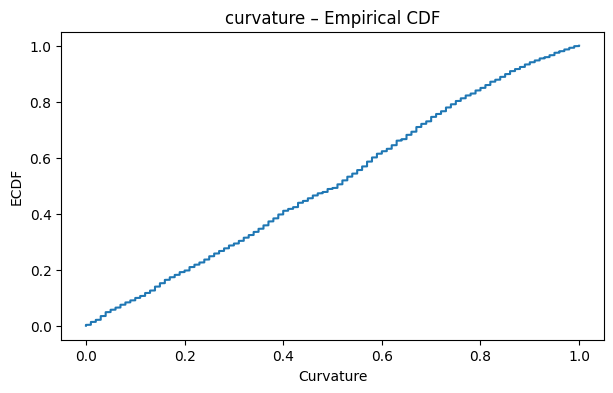

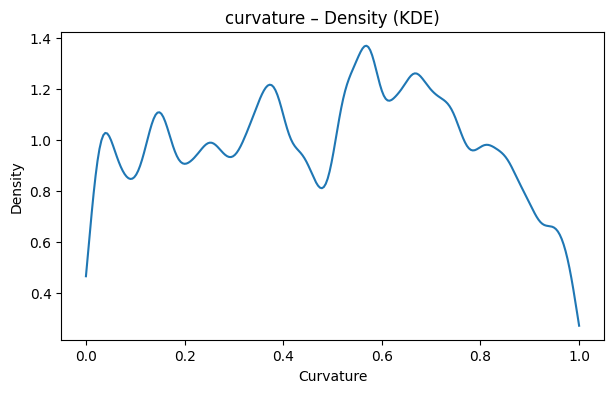

### Categorical Univariate

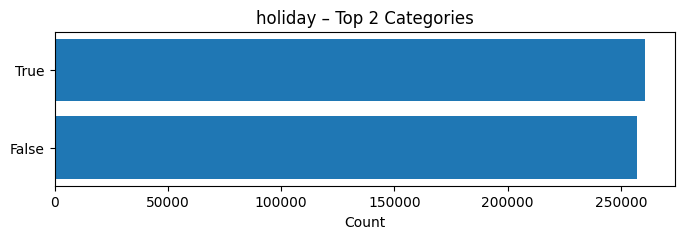

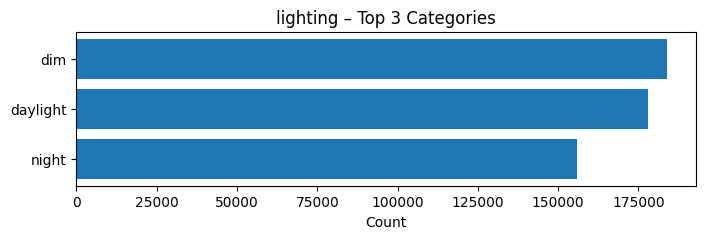

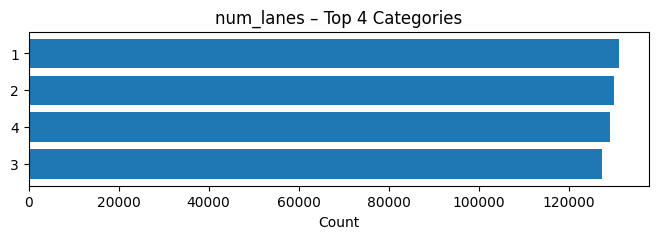

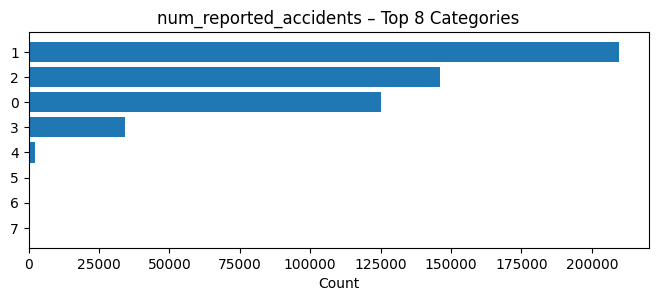

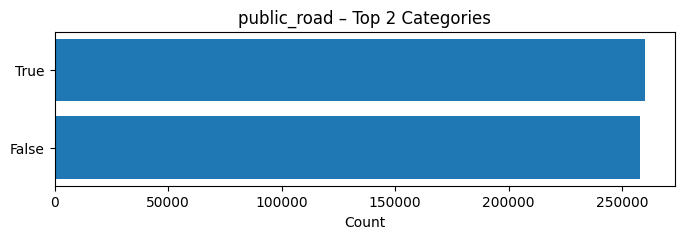

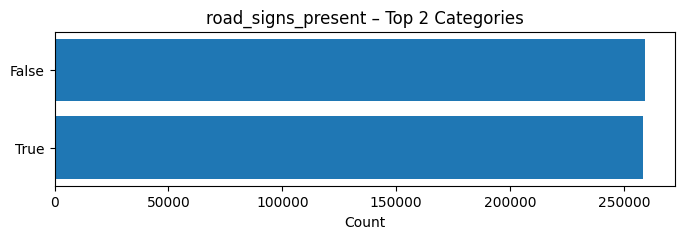

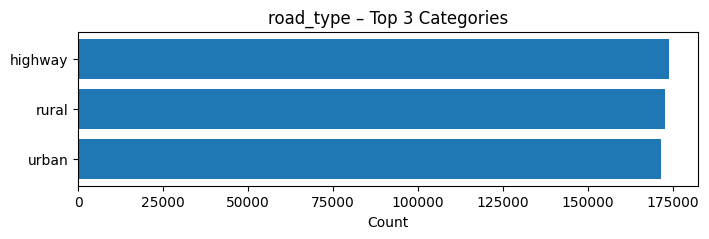

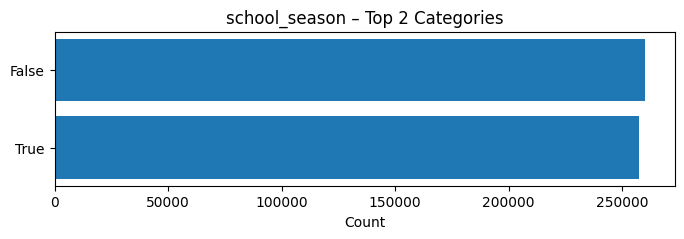

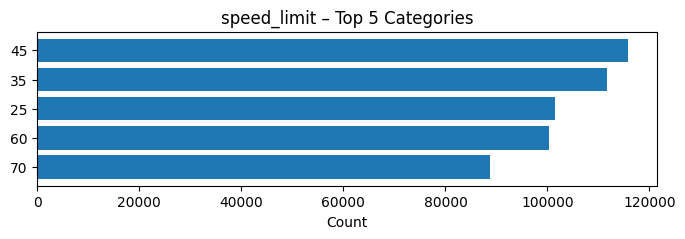

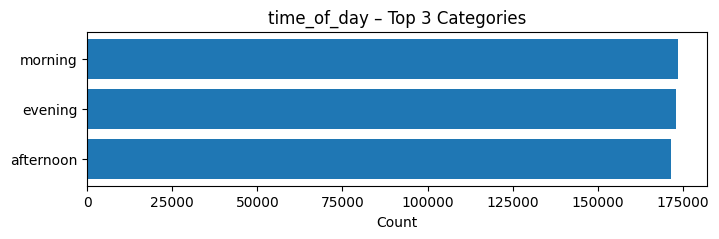

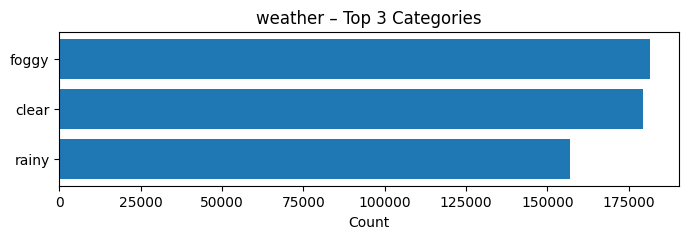

### Numeric → Target Lines (Discrete vs Continuous)

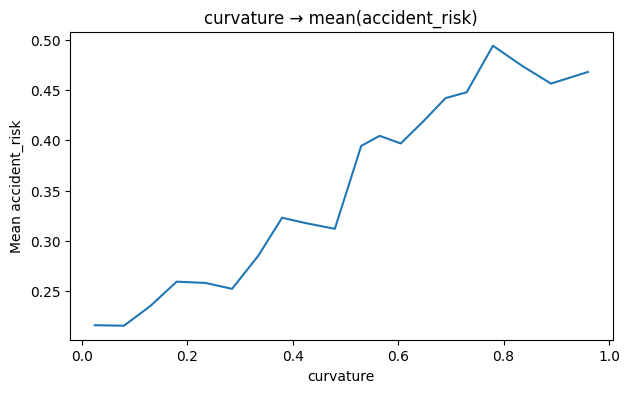

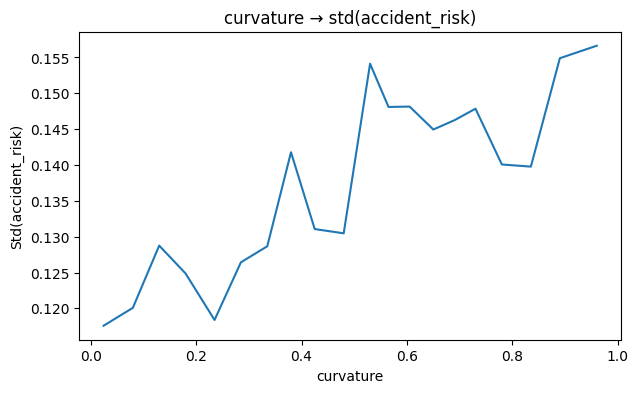

### Categorical → Target Bars

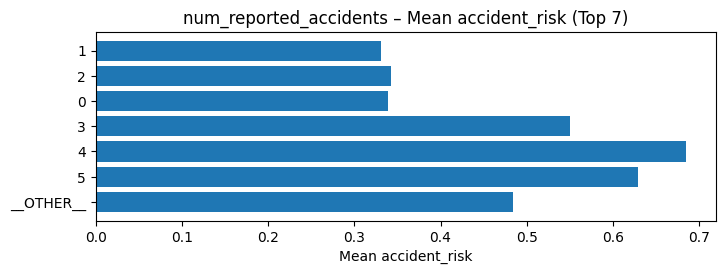

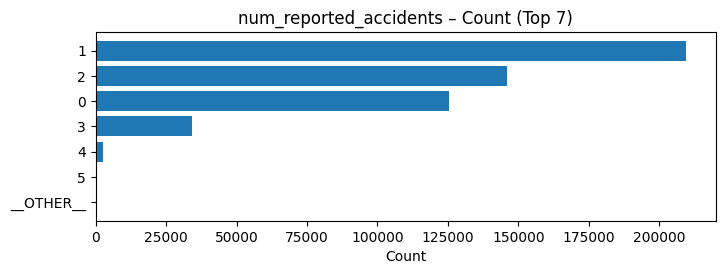

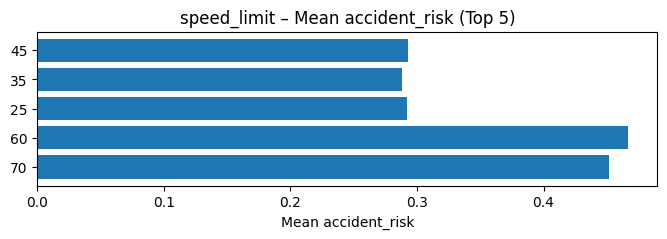

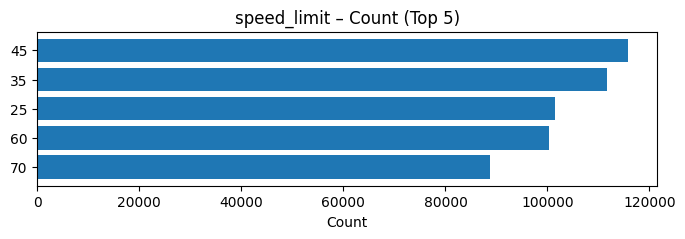

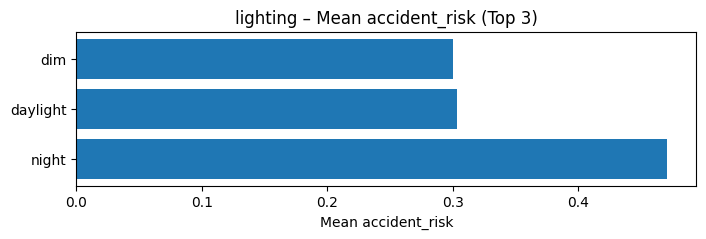

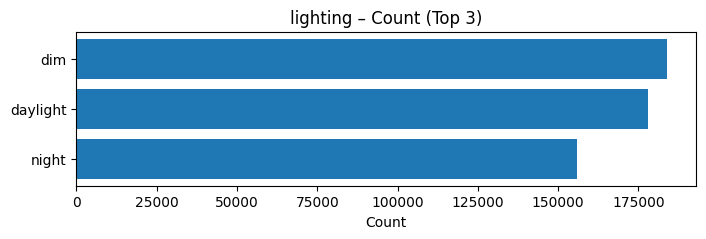

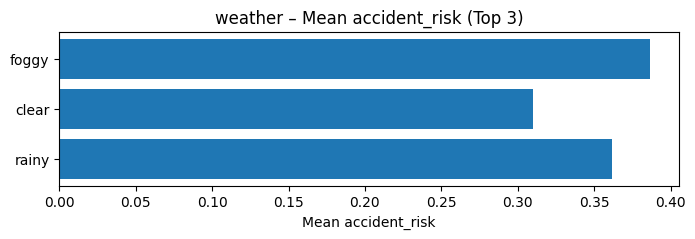

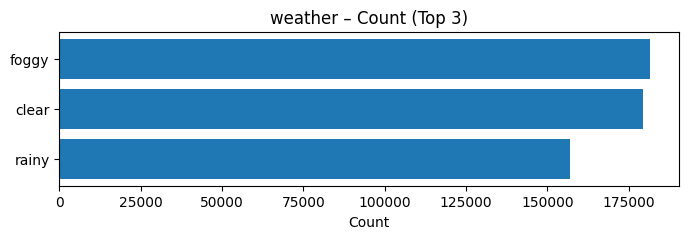

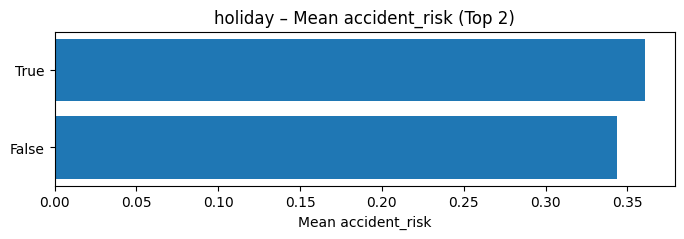

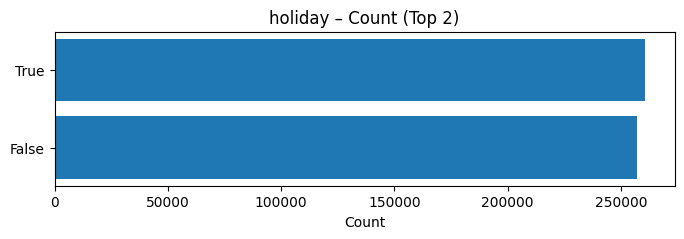

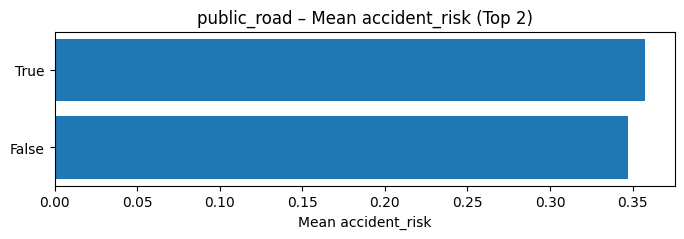

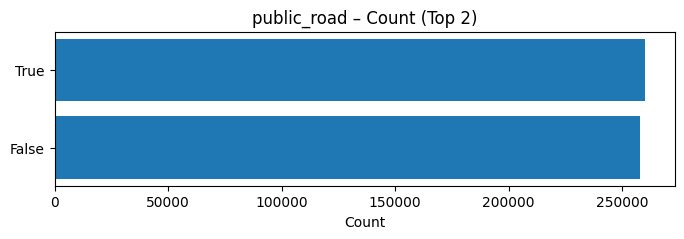

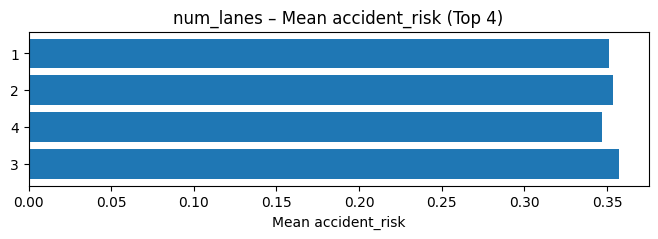

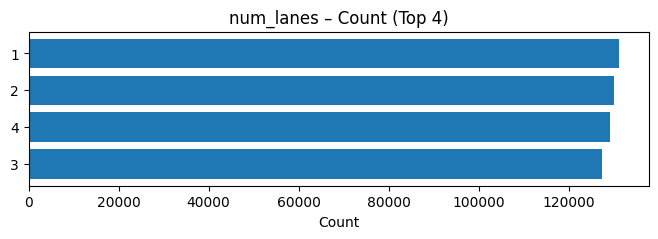

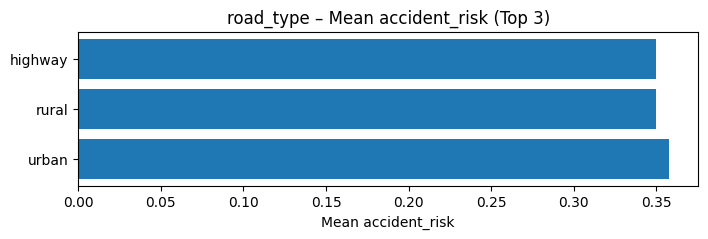

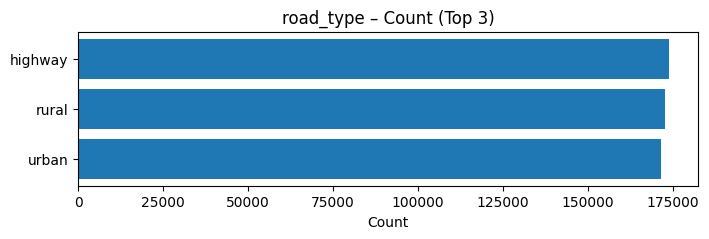

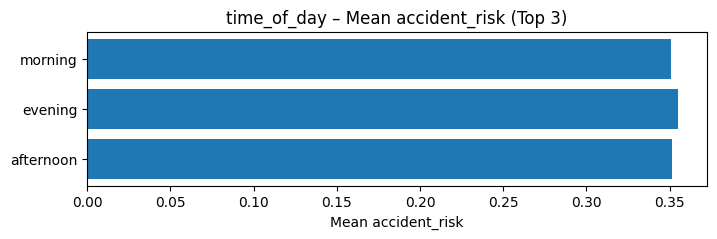

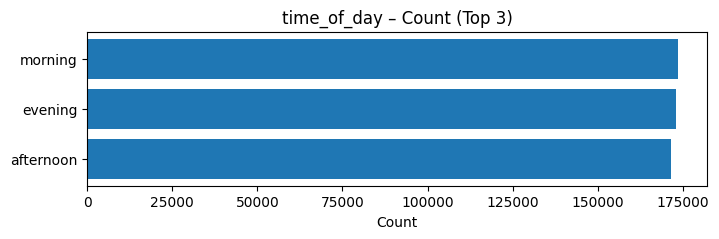

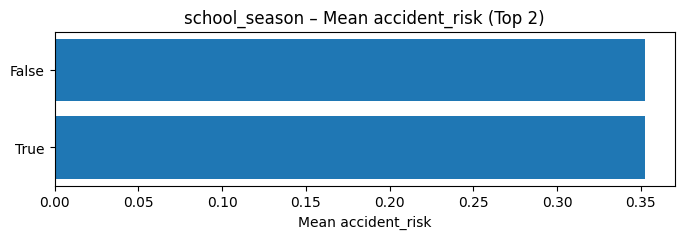

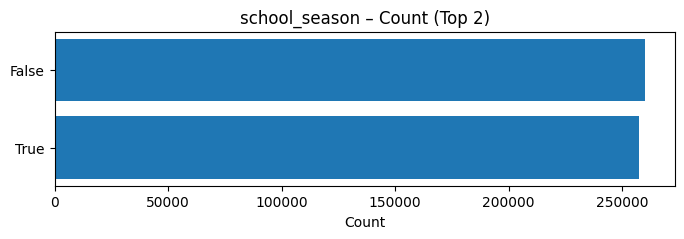

### Pair Plots

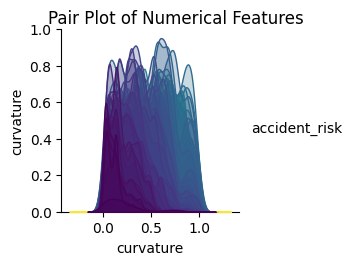

### Box Plots

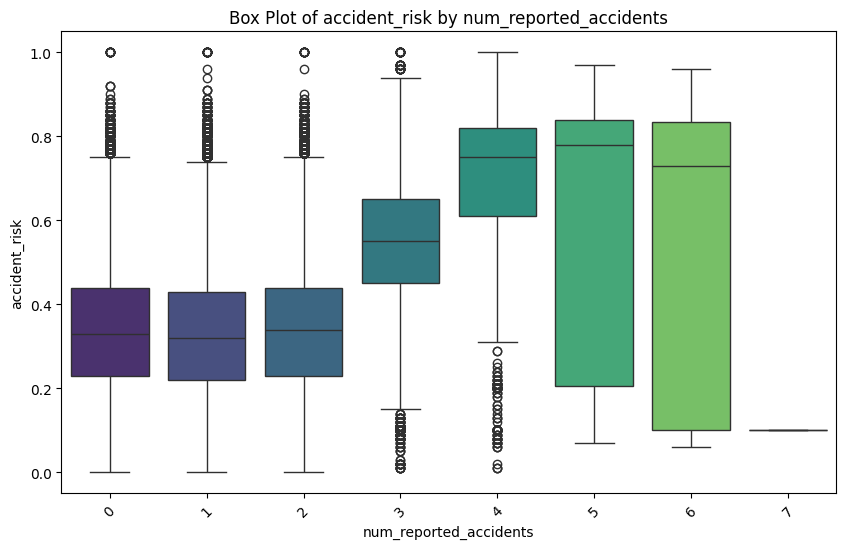

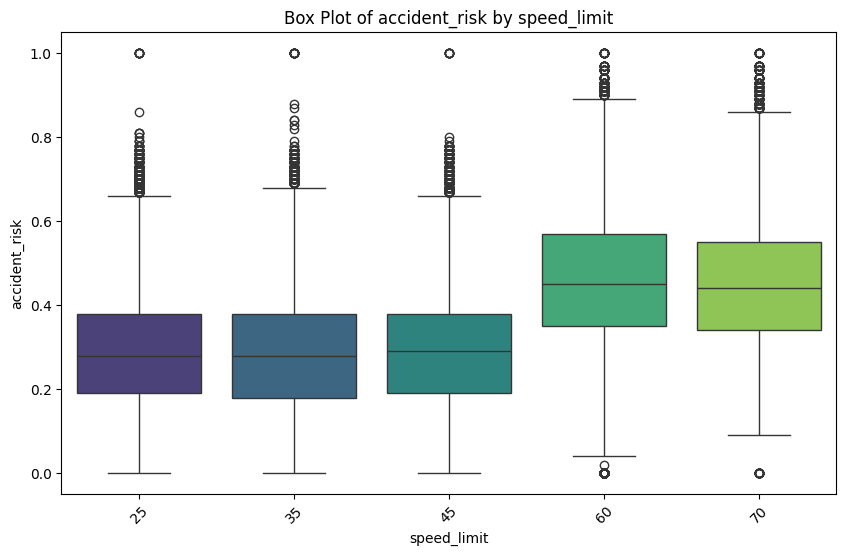

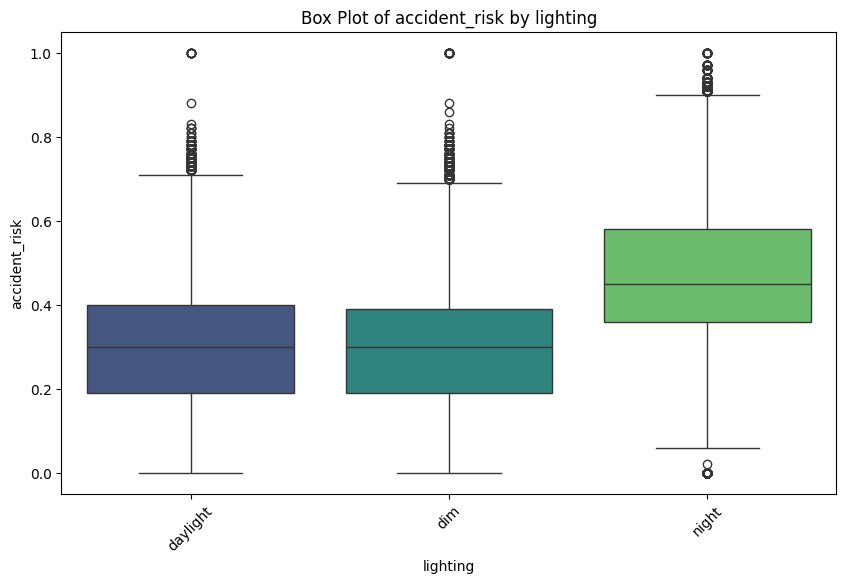

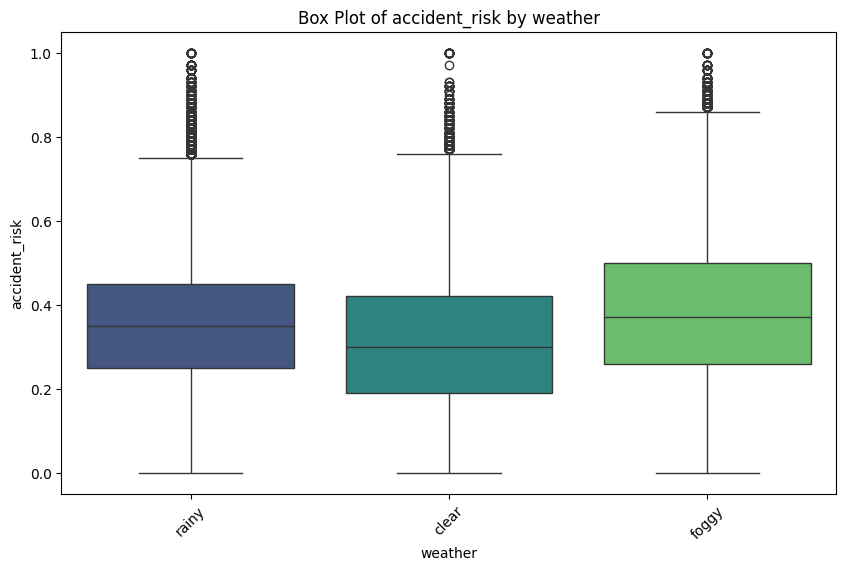

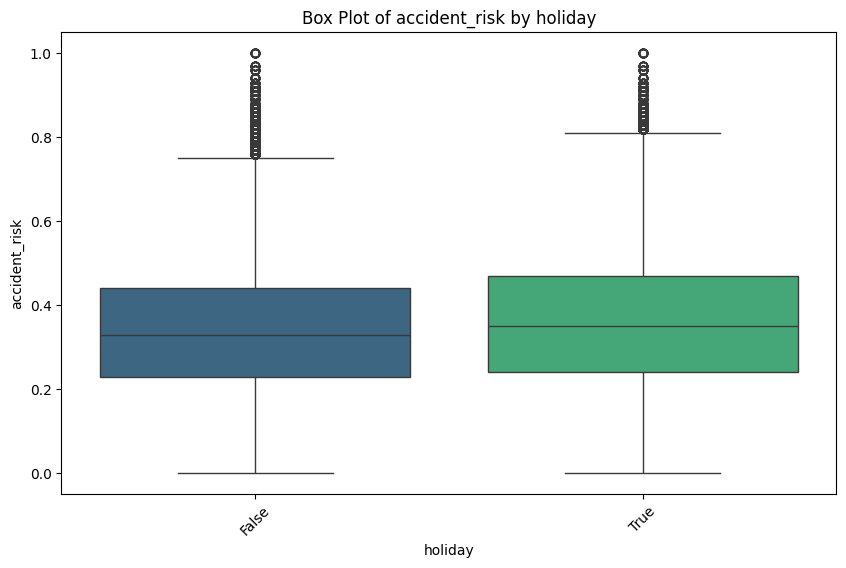

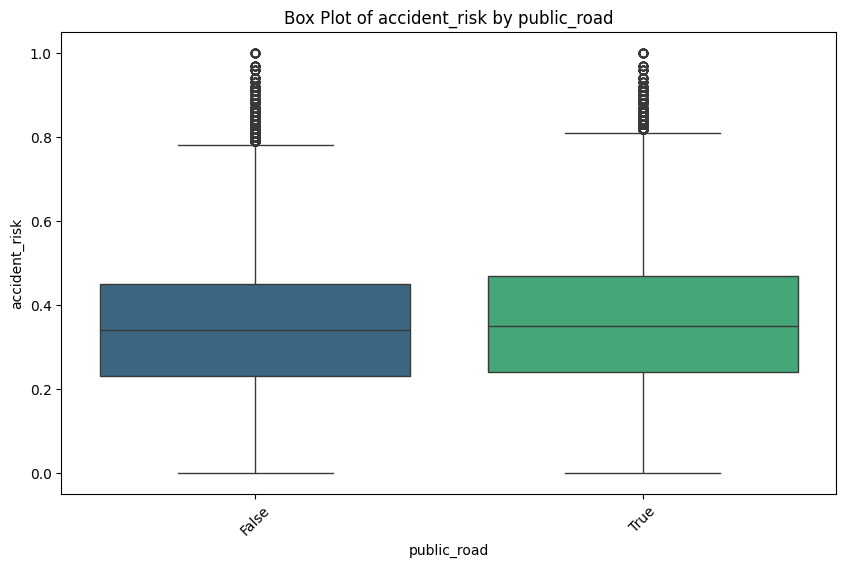

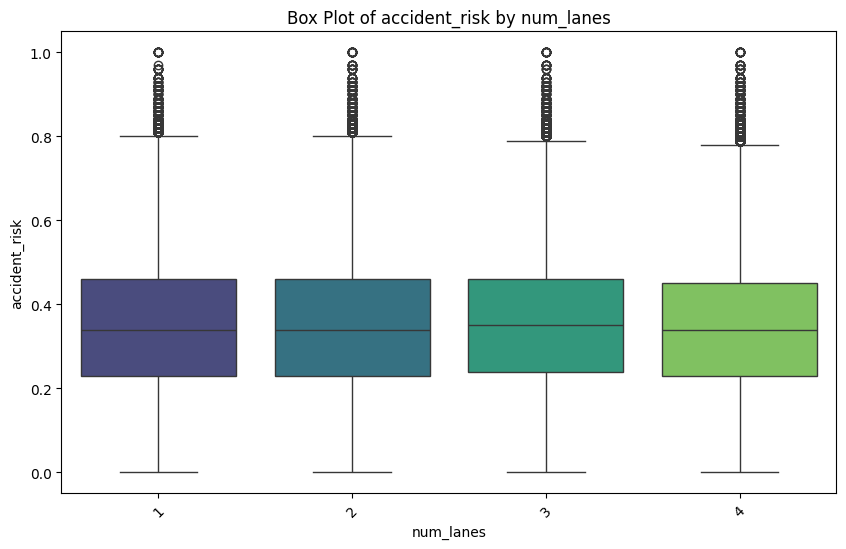

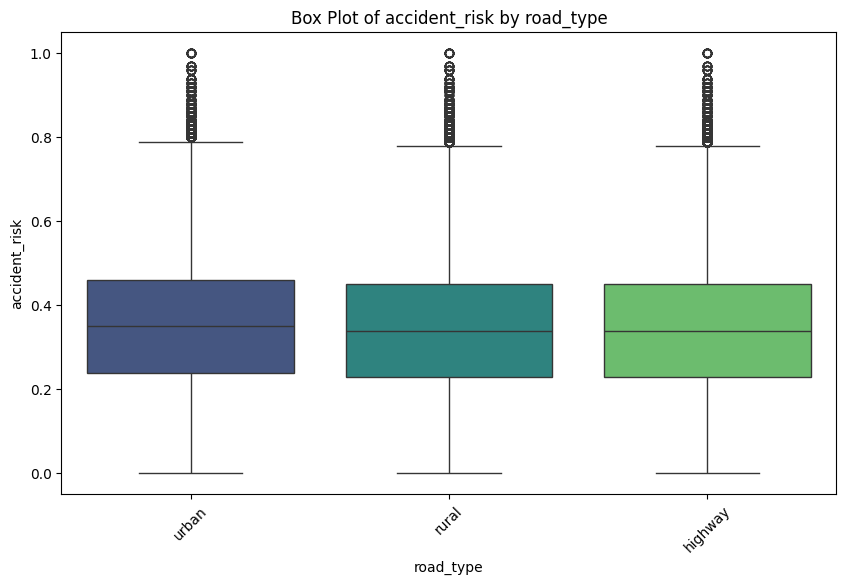

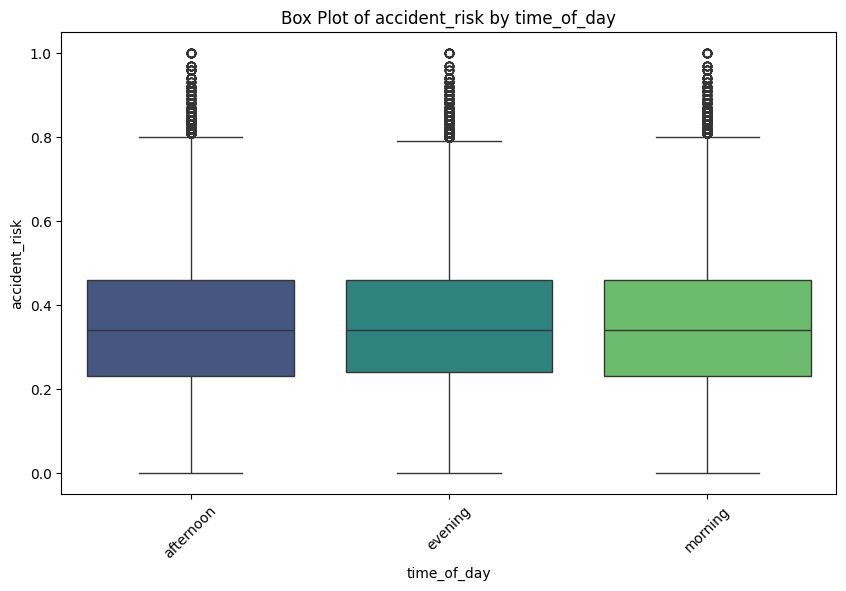

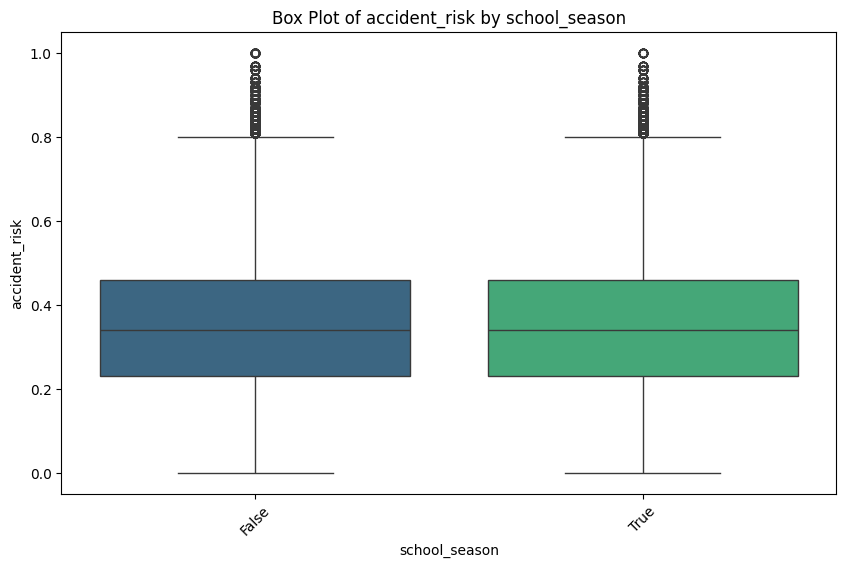

### Violin Plots

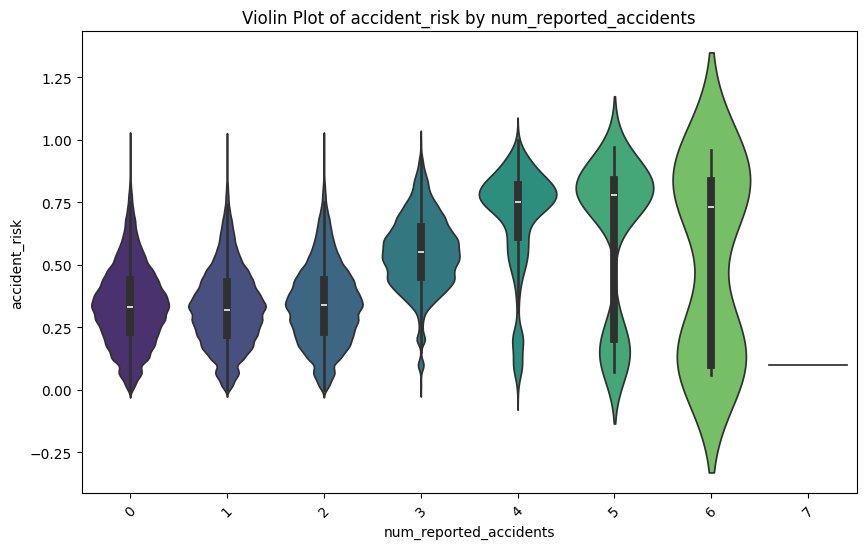

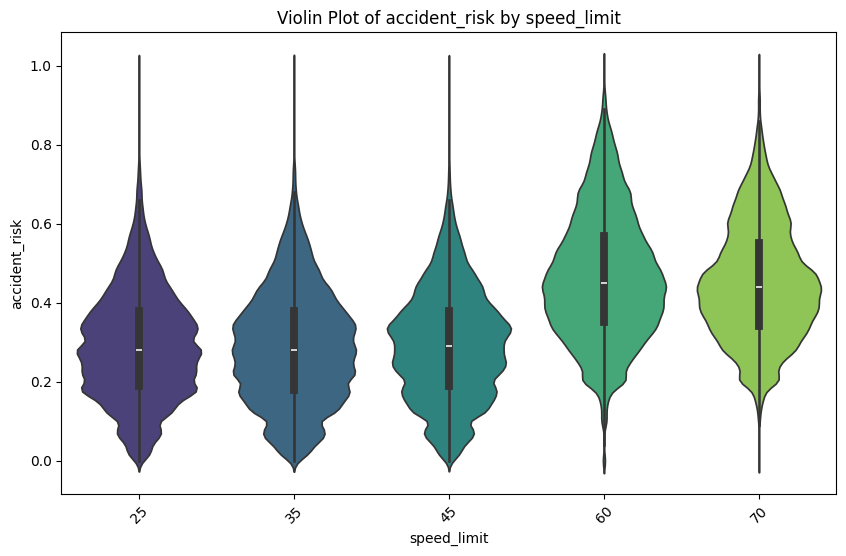

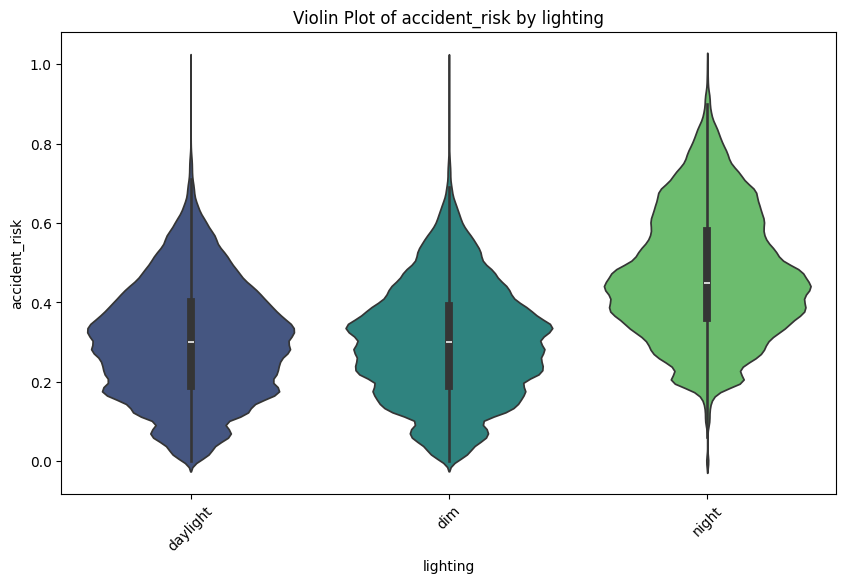

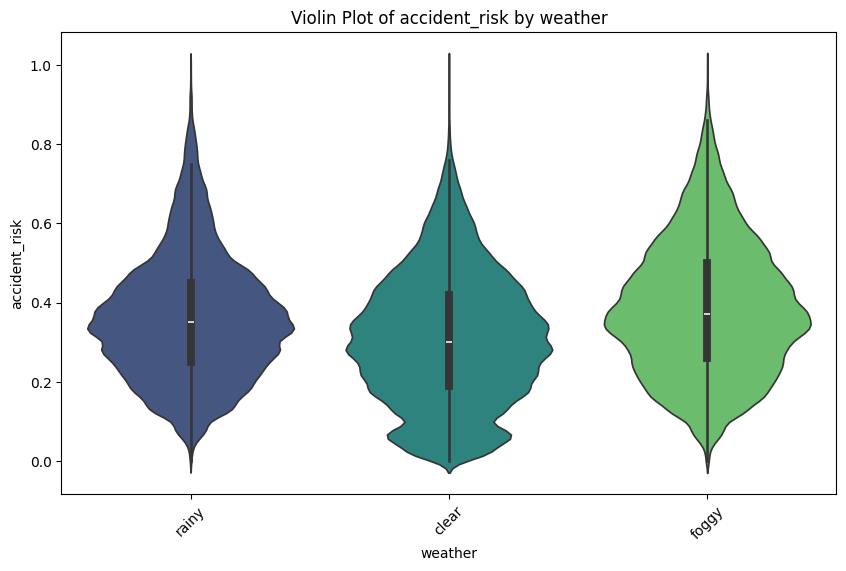

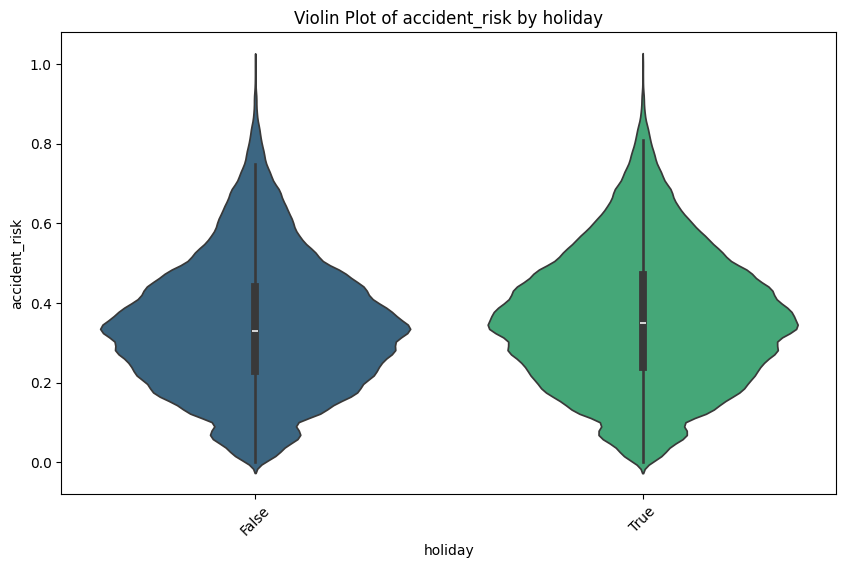

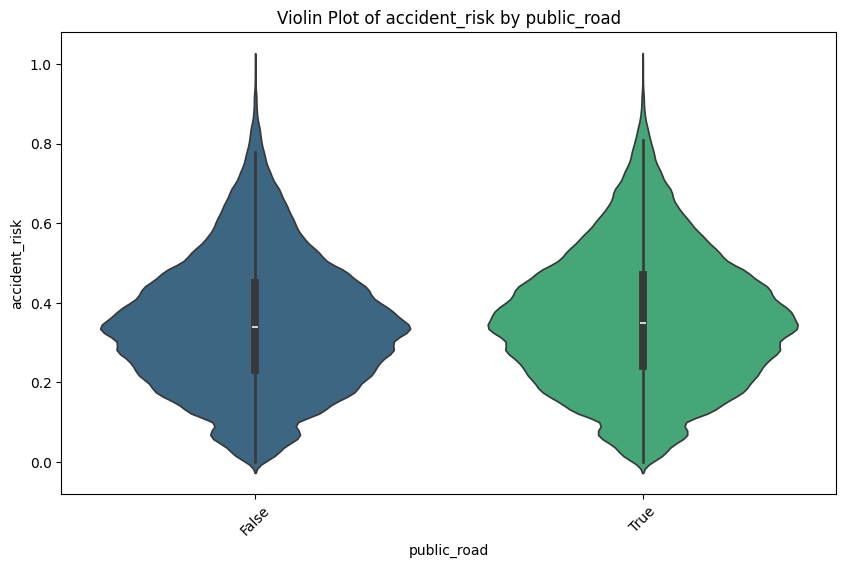

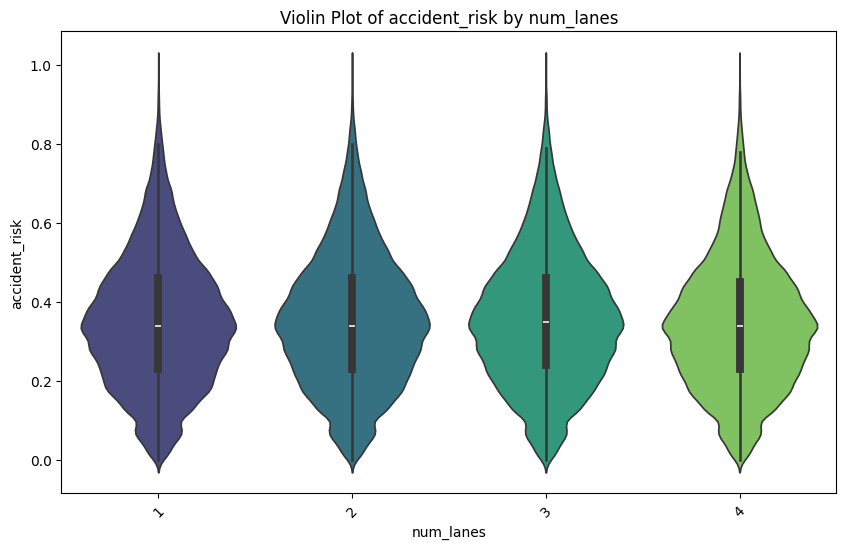

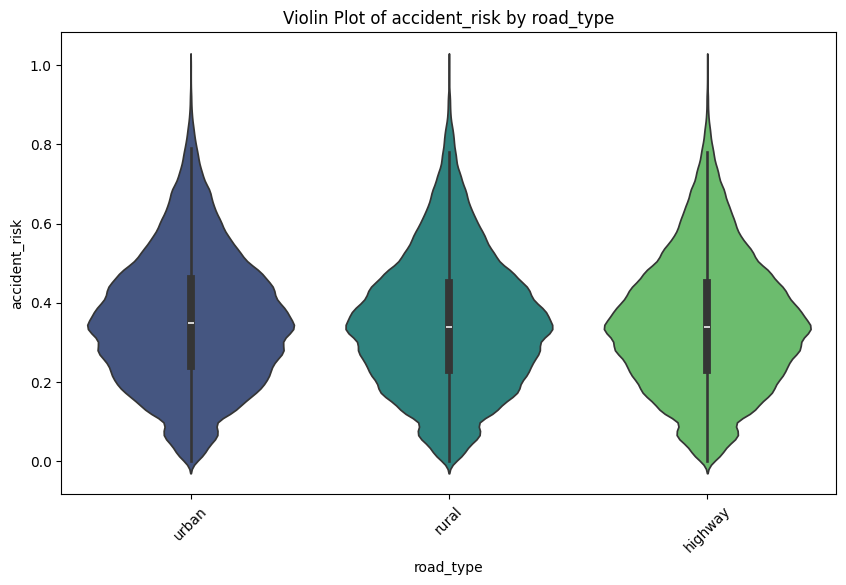

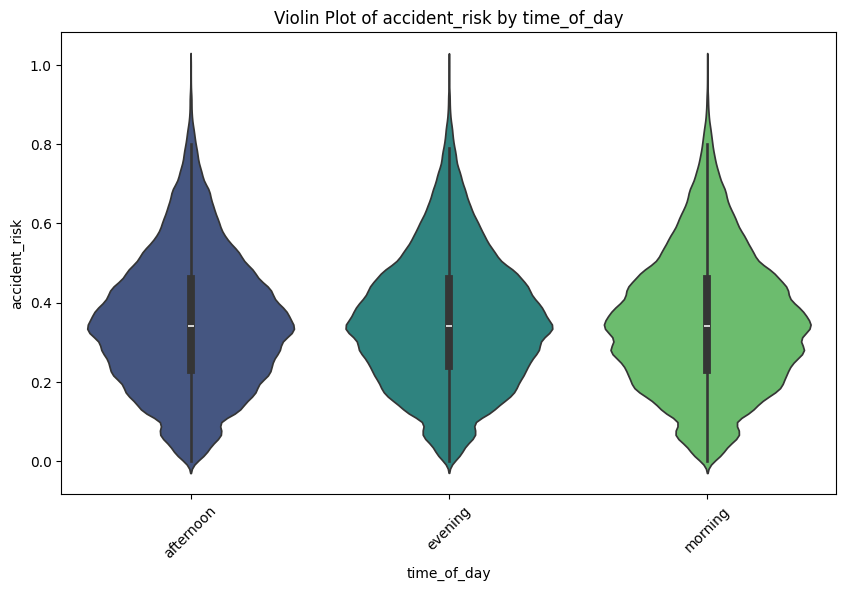

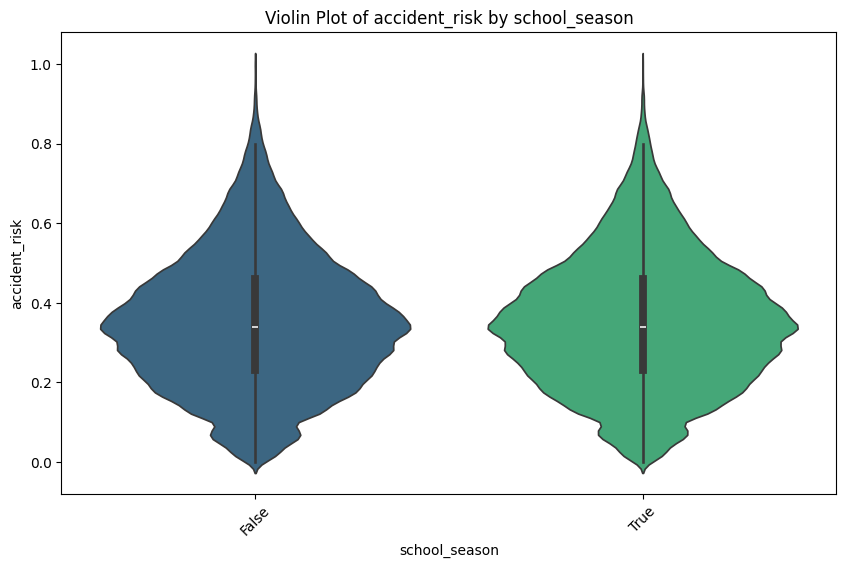

### Numeric × Categorical (Trend By Category)

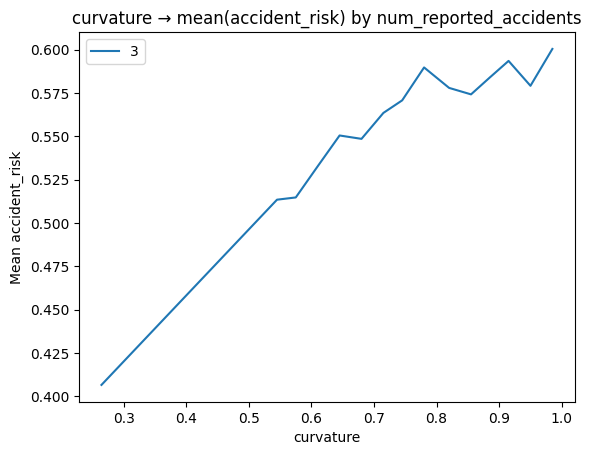

### Categorical × Categorical (Heatmap)

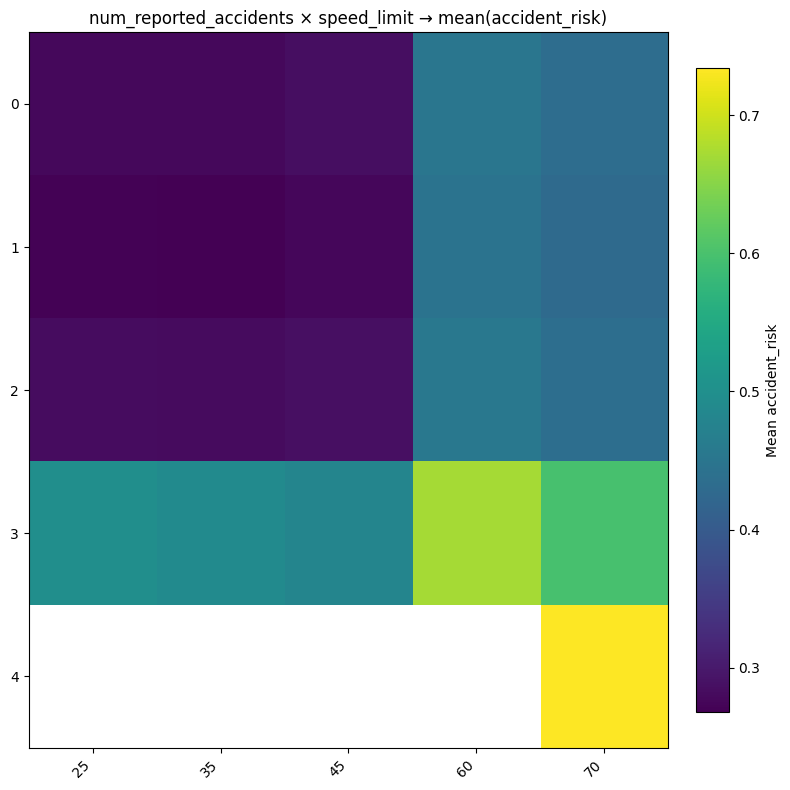

### Time of Day vs Risk Line

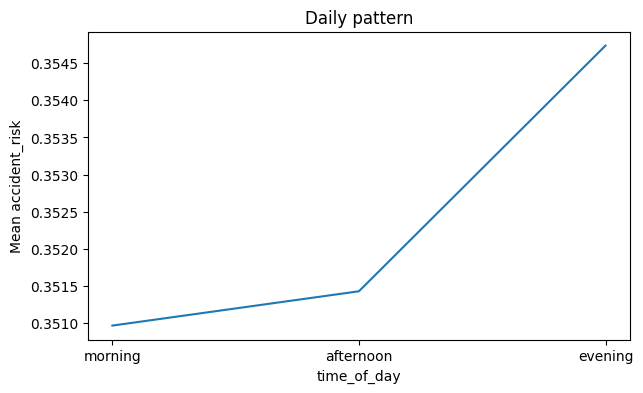

### Feature Signal Ranking

Top numeric (|Spearman|): [('curvature', 0.5467742572078576), ('speed_limit', 0.40914437276337084), ('num_reported_accidents', 0.15426290391245698), ('num_lanes', -0.007230978036206295)]
Top categorical (range of mean risk): [('lighting', 0.1703579791069305, 3), ('weather', 0.07624463499104406, 3), ('holiday', 0.017017868121310176, 2), ('public_road', 0.010328730695673638, 2), ('road_type', 0.007721712947188375, 3), ('time_of_day', 0.003769930463624338, 3), ('school_season', 0.0003251453185004194, 2), ('road_signs_present', 0.00020947831427381436, 2)]


In [36]:
run_eda(training_df, target = TARGET, max_cat_card = 30)

## Test Dataset EDA

Columns → numeric: 1, categorical≤30: 11


### Leakage

Dataframe doesn't have a target column accident_risk.


### Missingness

No missing values.


### Numeric Univariate

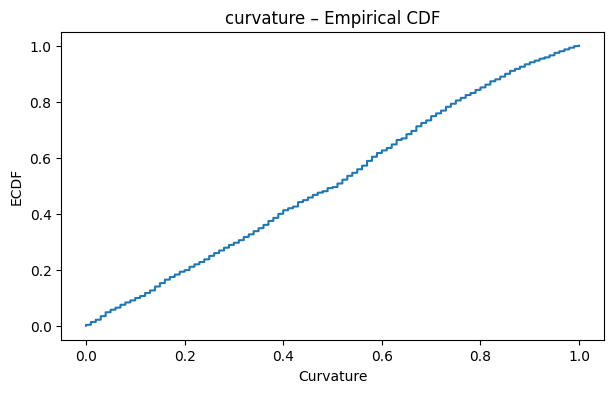

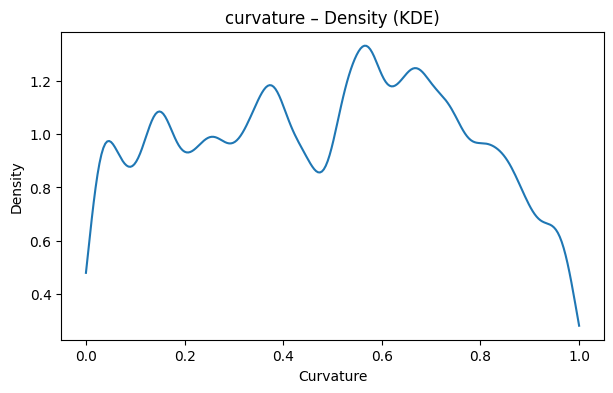

### Categorical Univariate

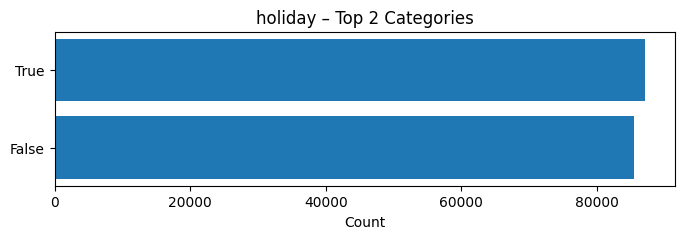

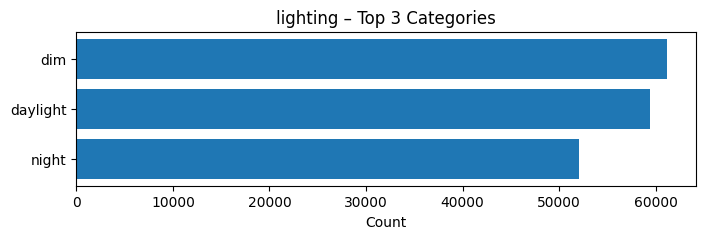

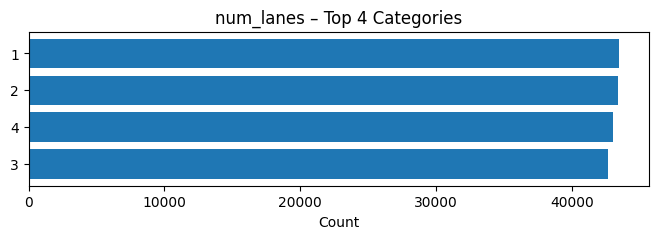

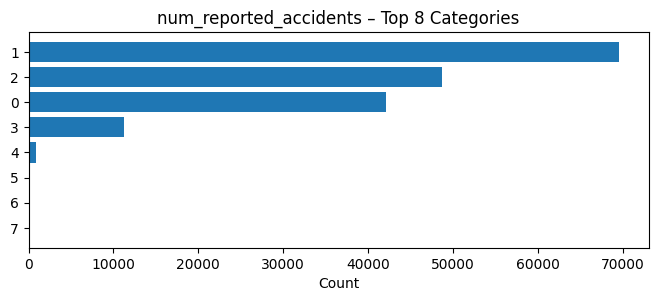

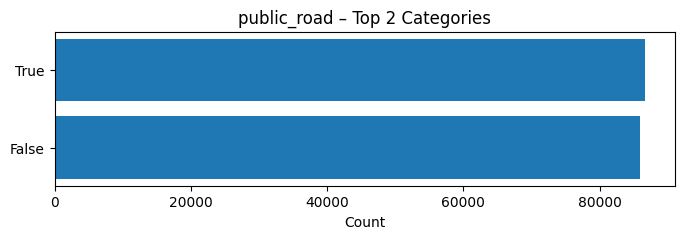

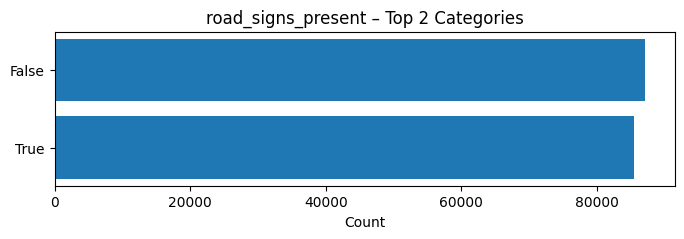

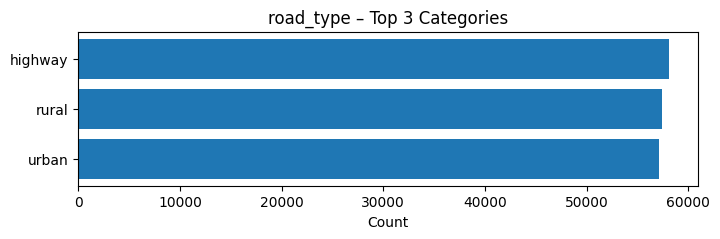

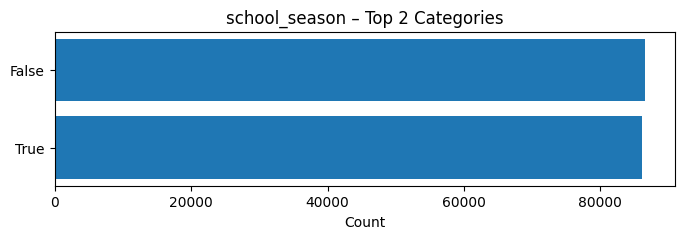

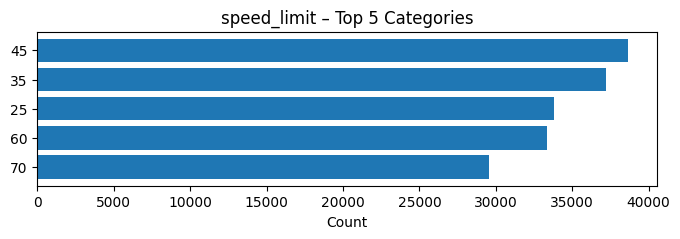

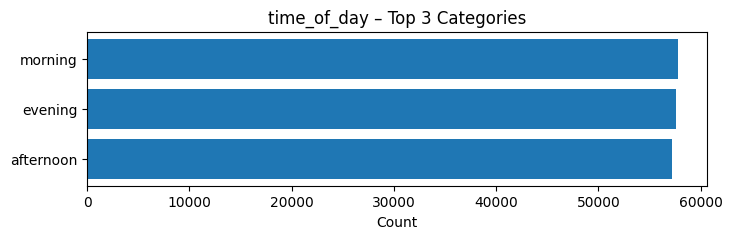

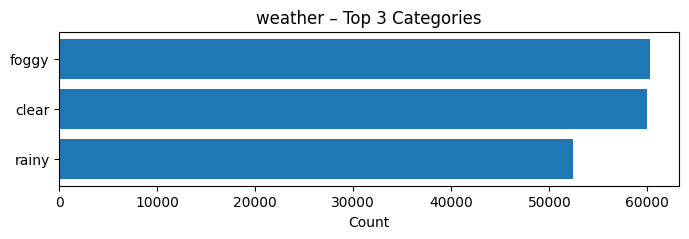

Target not present → skipping target-aware plots.


In [37]:
run_eda(test_df, target = TARGET, max_cat_card = 30)

## Examine Original Dataset

In [38]:
ORIGINAL_DIR = Path("/kaggle/input/simulated-roads-accident-data") if running_in_kaggle() else Path("original_data")

original_df = pd.read_csv(ORIGINAL_DIR / 'synthetic_road_accidents_100k.csv')
original_df

road_type  num_lanes  curvature  speed_limit  lighting weather  \
0         rural          2      0.290           70     night   rainy   
1       highway          1      0.340           25       dim   clear   
2         rural          2      0.760           70     night   foggy   
3         rural          3      0.370           70     night   foggy   
4       highway          3      0.390           45       dim   rainy   
...         ...        ...        ...          ...       ...     ...   
99995     rural          2      0.610           60       dim   foggy   
99996     rural          2      0.520           35       dim   foggy   
99997     rural          2      0.080           70  daylight   clear   
99998     rural          1      0.830           70       dim   foggy   
99999     rural          2      0.010           45  daylight   foggy   

       road_signs_present  public_road time_of_day  holiday  school_season  \
0                   False         True     evening    False          False   
1                   False        False     morning    False          False   
2                    True        False     evening     True           True   
3                    True        False     morning    False           True   
4                   False         True     morning    False          False   
...                   ...          ...         ...      ...            ...   
99995               False         True     evening    False          False   
99996                True         True   afternoon    False          False   
99997               False        False     evening     True          False   
99998               False         True     morning    False           True   
99999               False         True     evening     True          False   

       num_reported_accidents  accident_risk  
0                           1          0.640  
1                           3          0.270  
2                           1          0.760  
3                           0          0.600  
4                           0          0.170  
...                       ...            ...  
99995                       1          0.540  
99996                       1          0.180  
99997                       1          0.200  
99998                       0          0.580  
99999                       2          0.140  

[100000 rows x 13 columns]

## Original Dataset EDA

Columns → numeric: 1, categorical≤30: 11


### Leakage

min=0.0000, max=1.0000
mass at 0: 0.853%, mass at 1: 0.002%
num_reported_accidents: Pearson r = 0.171 (check this column carefully)


### Missingness

No missing values.


### Numeric Univariate

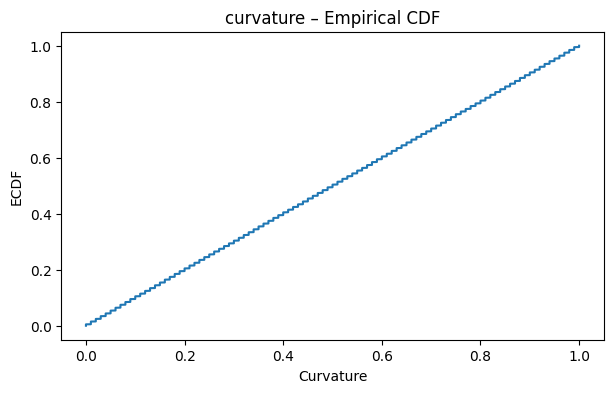

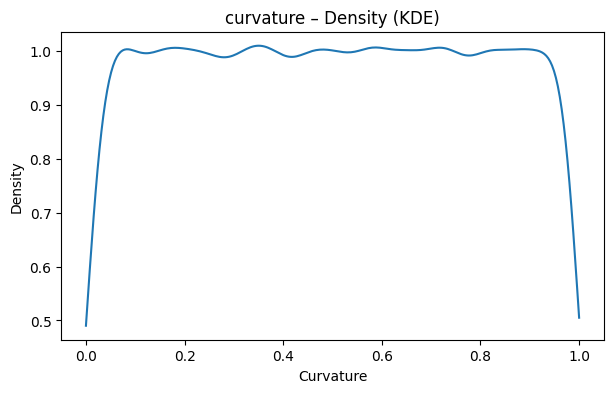

### Categorical Univariate

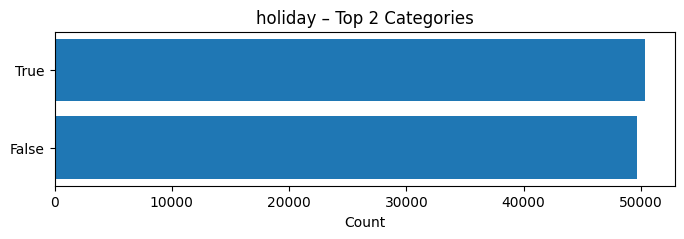

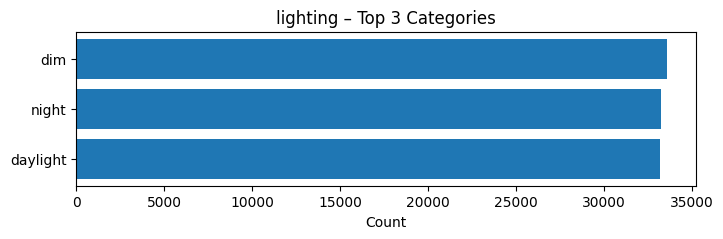

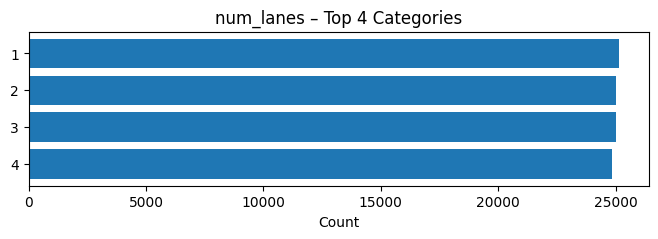

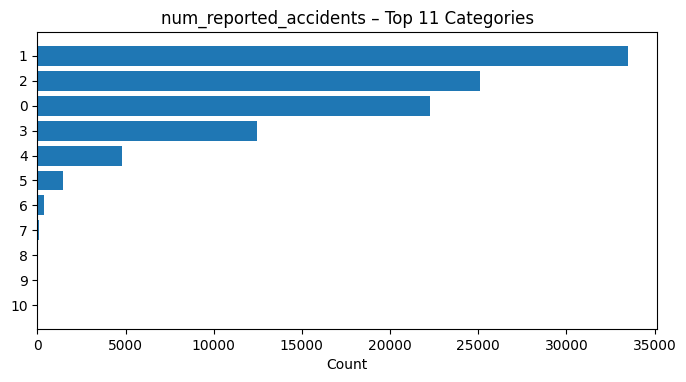

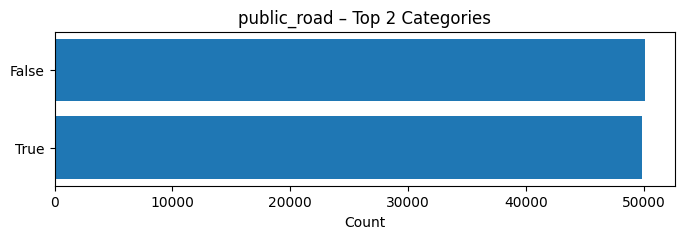

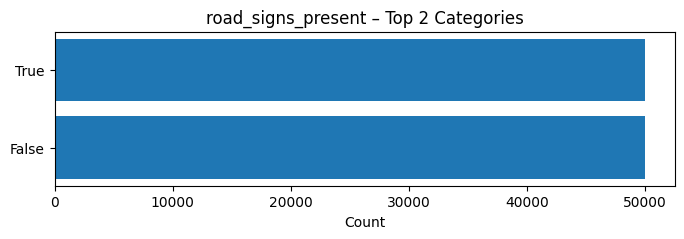

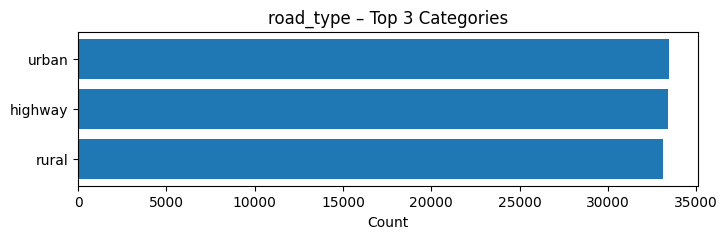

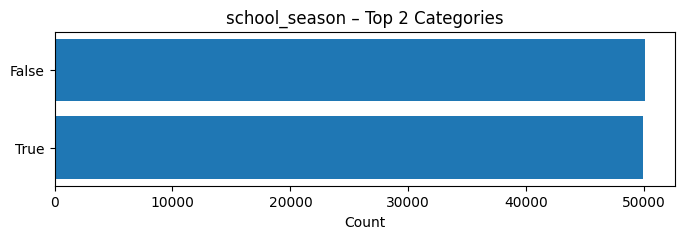

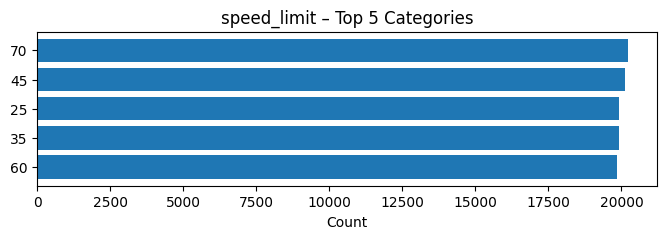

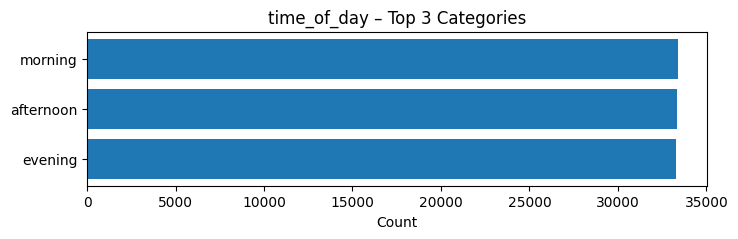

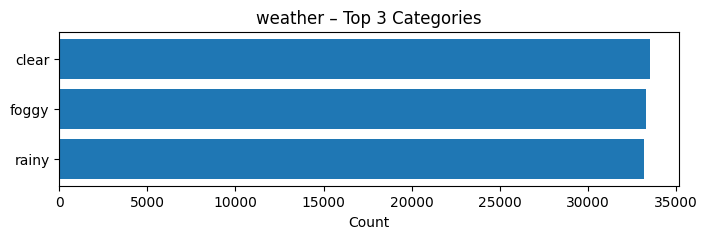

### Numeric → Target Lines (Discrete vs Continuous)

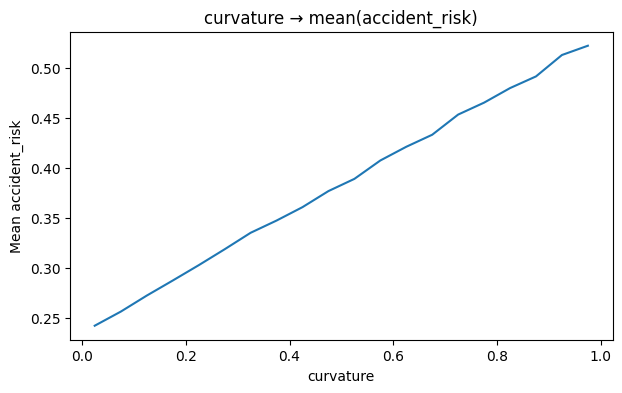

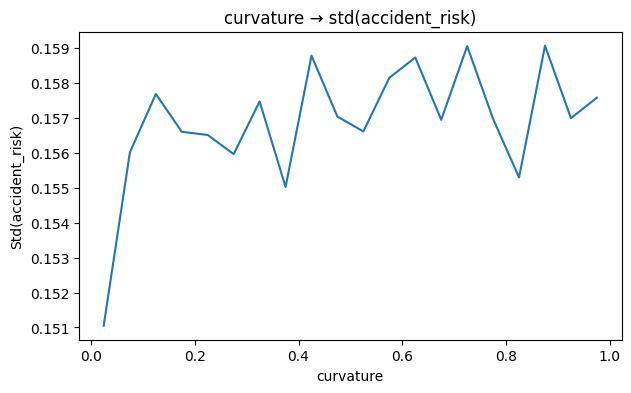

### Categorical → Target Bars

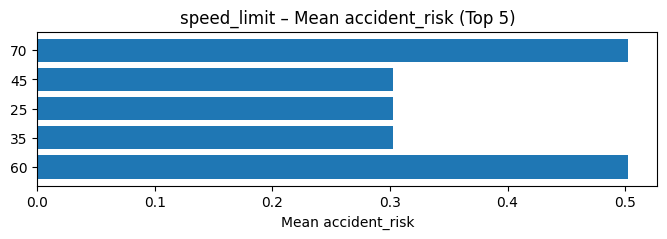

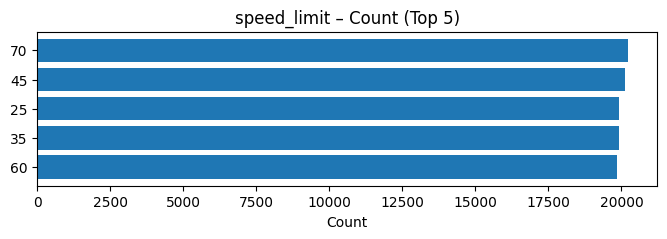

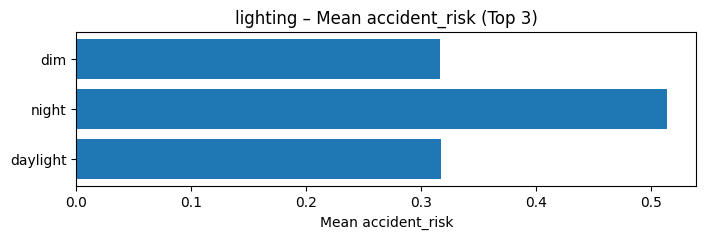

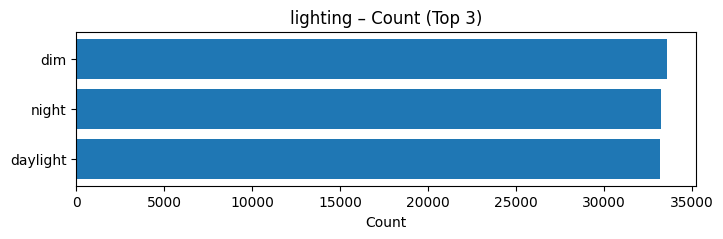

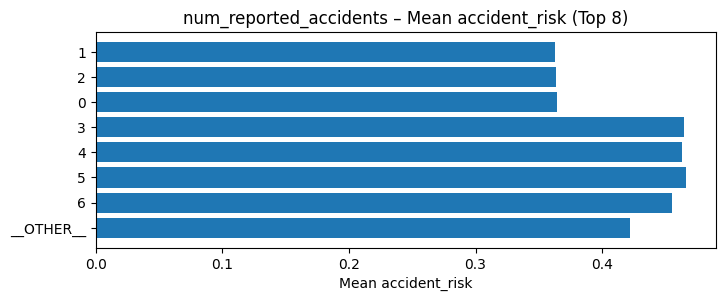

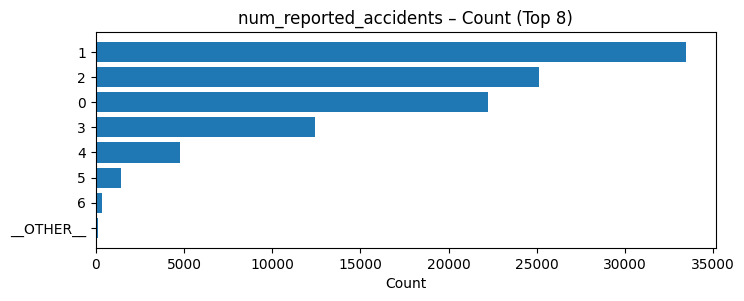

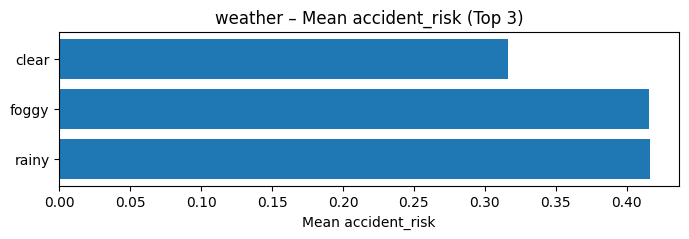

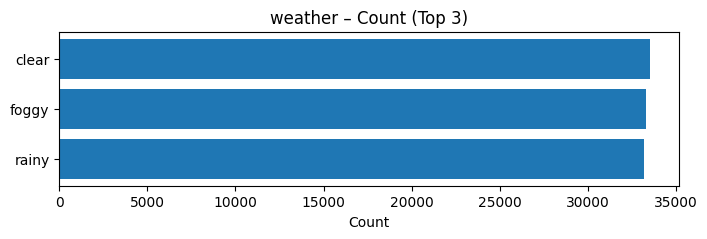

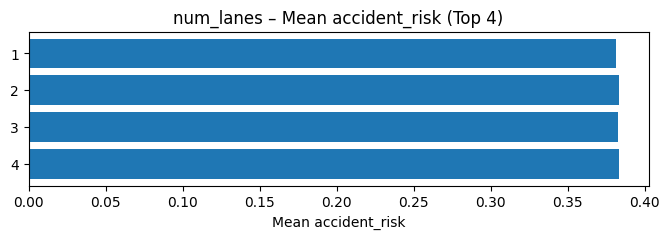

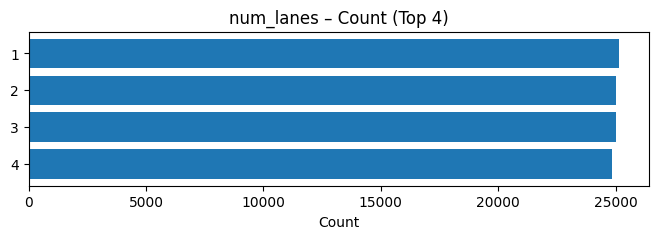

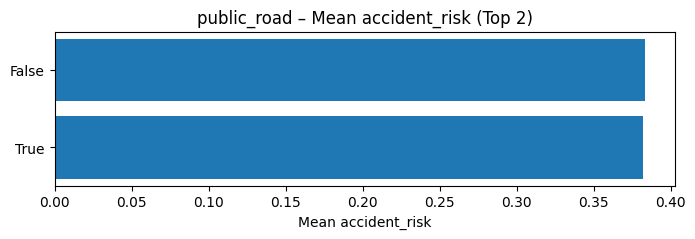

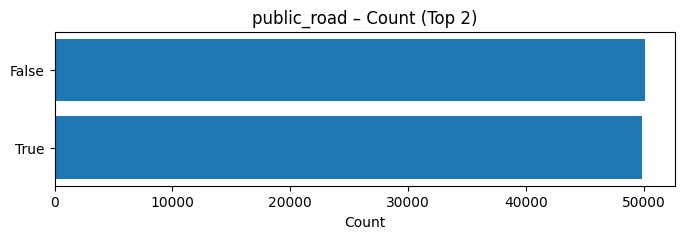

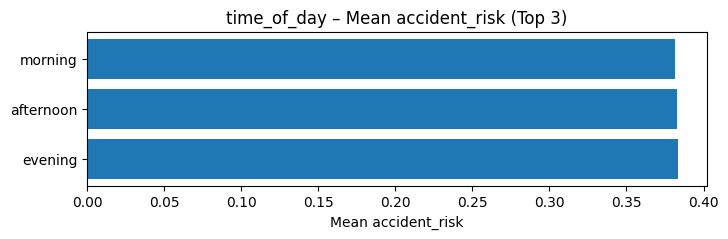

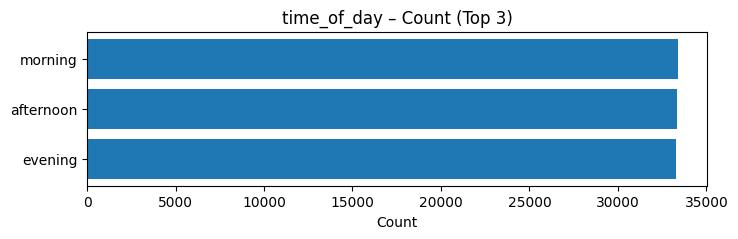

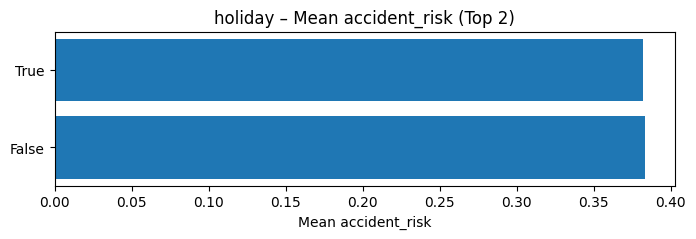

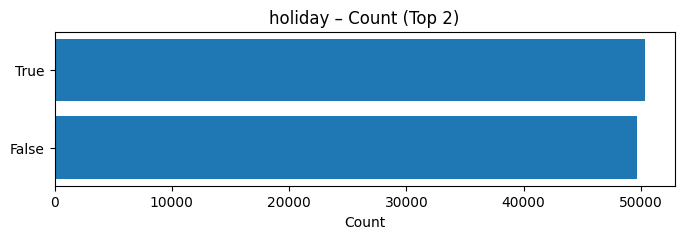

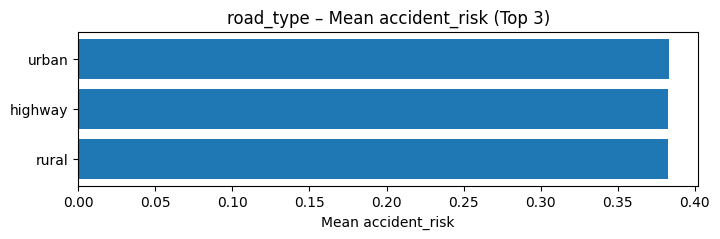

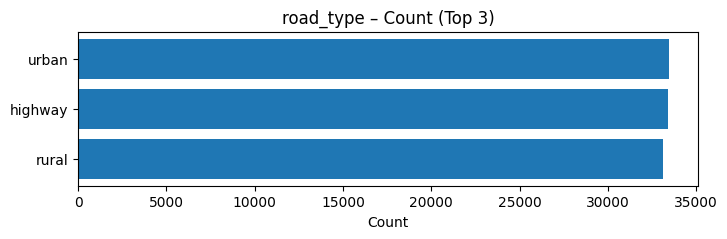

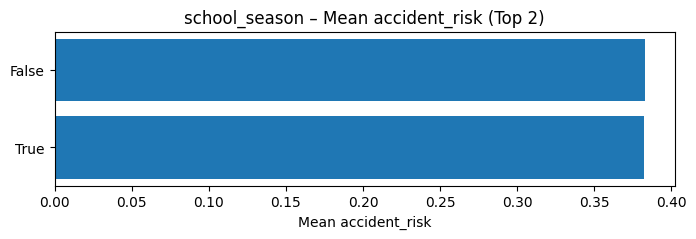

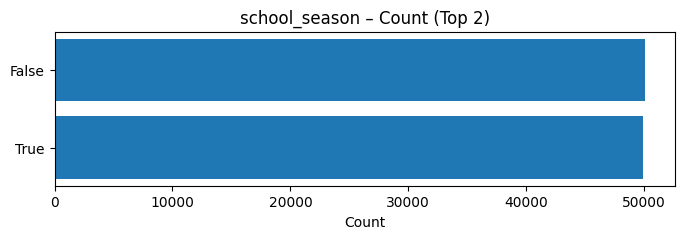

### Pair Plots

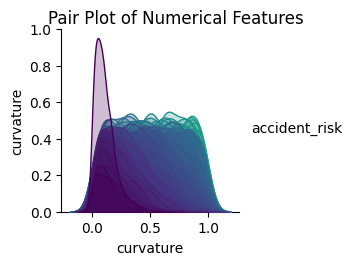

### Box Plots

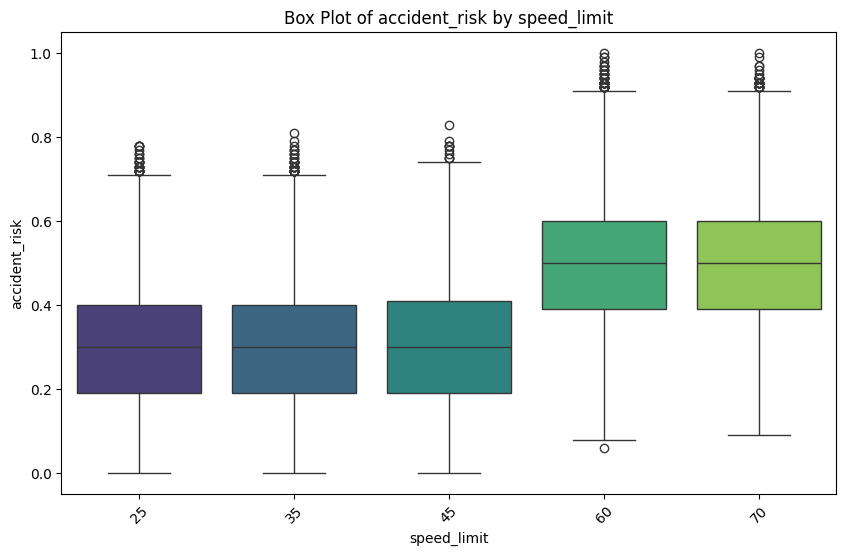

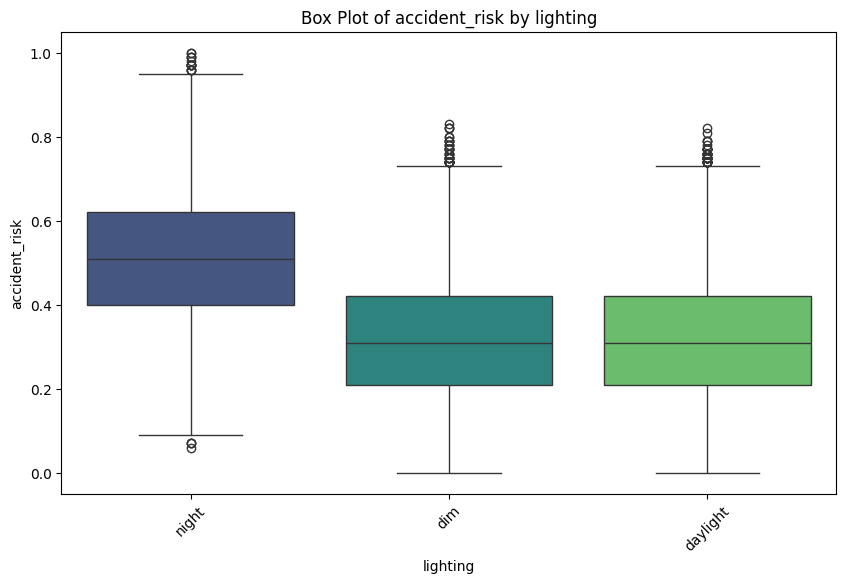

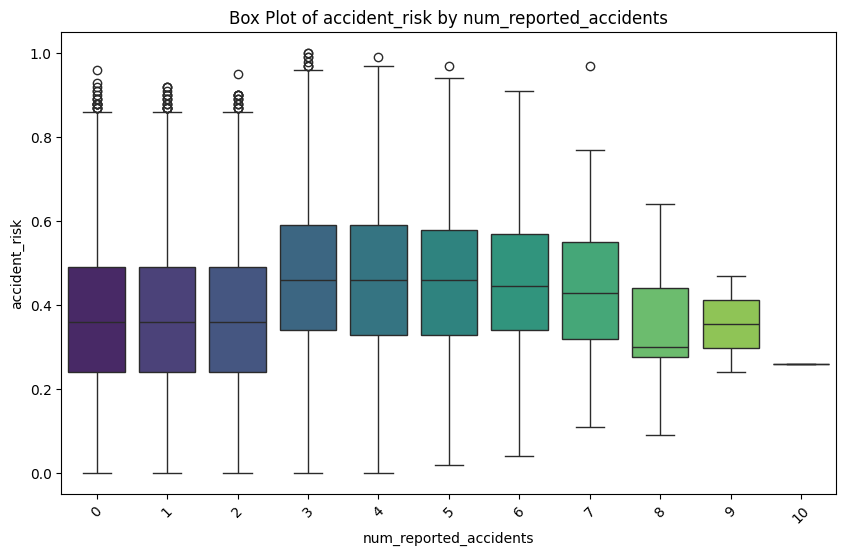

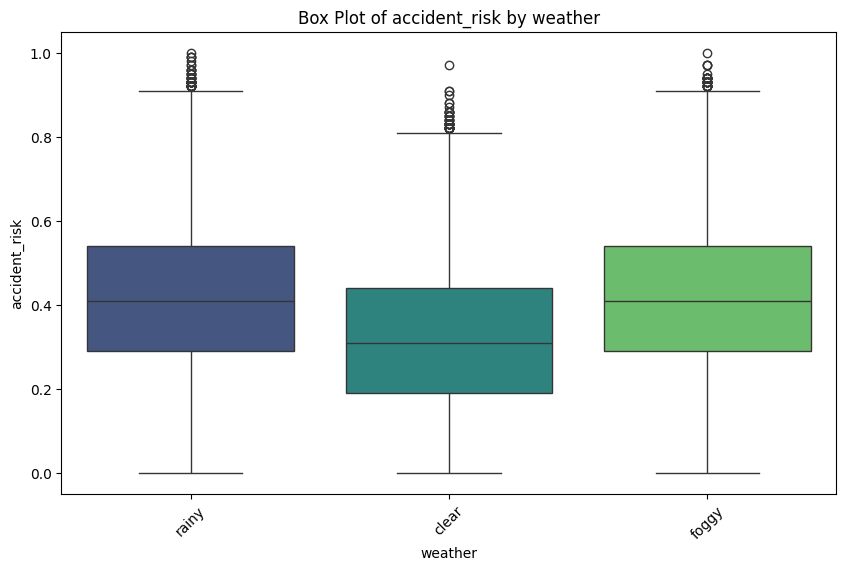

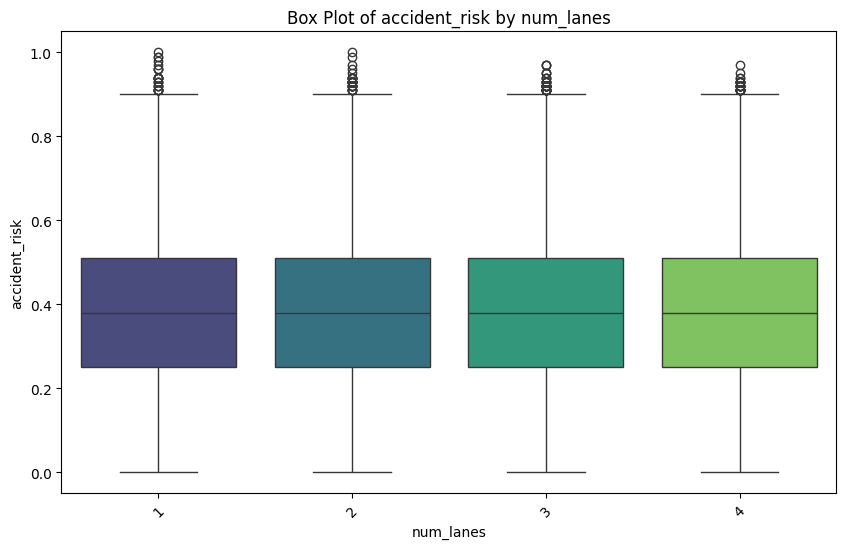

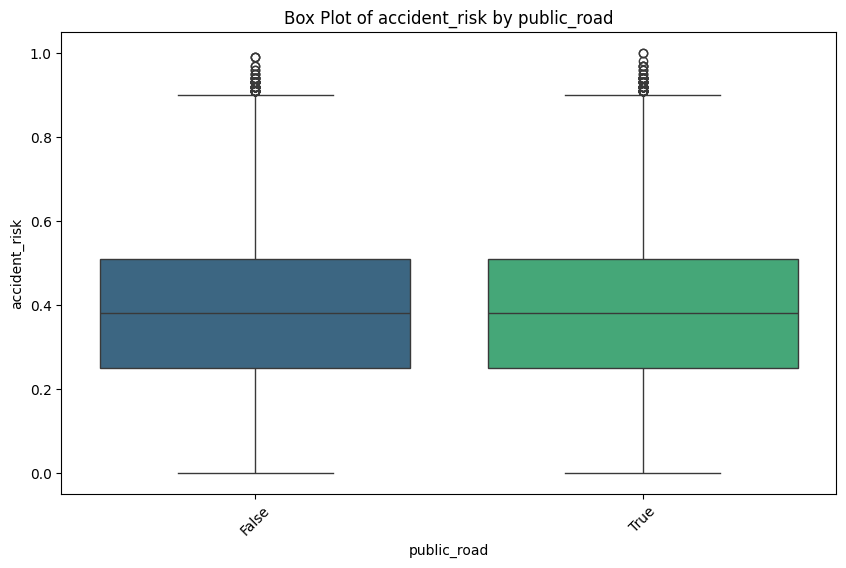

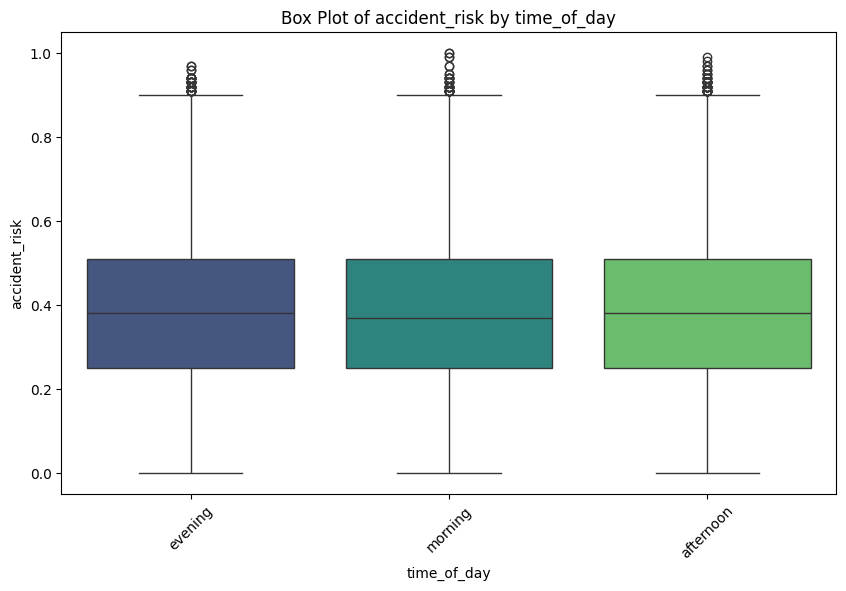

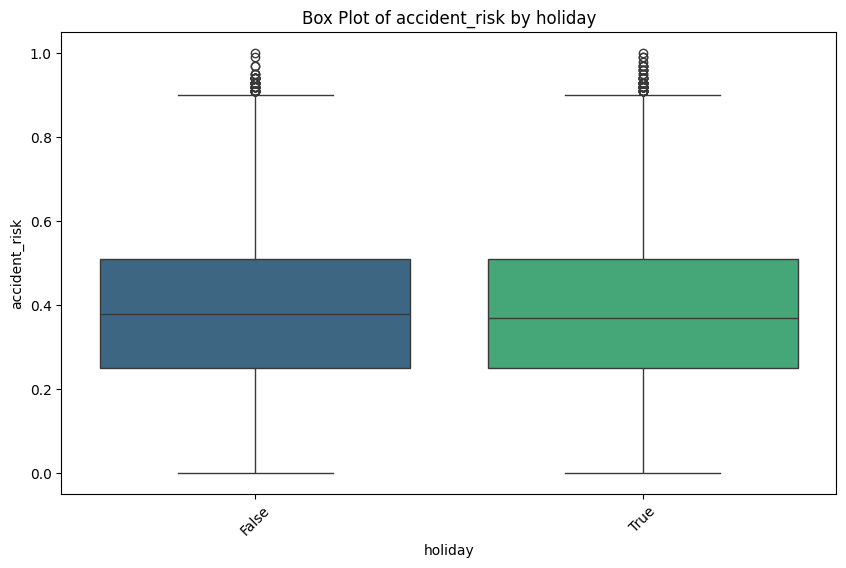

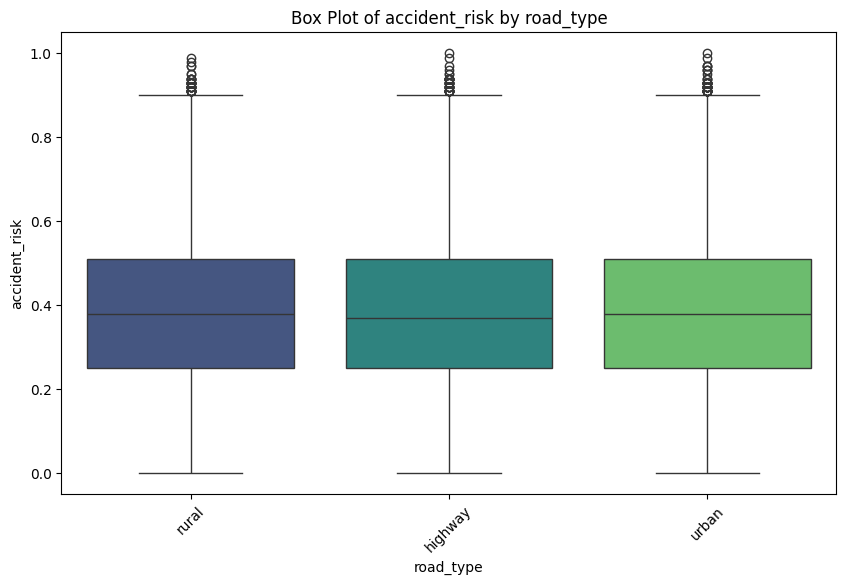

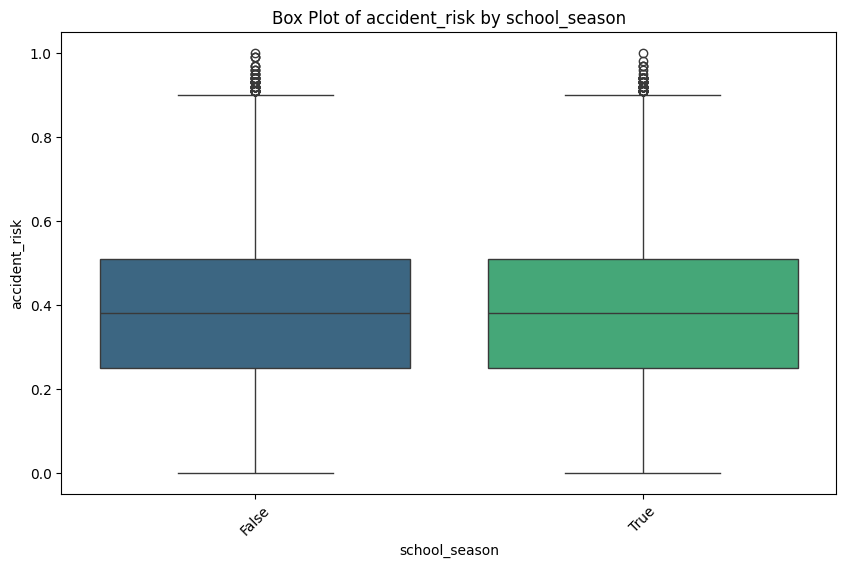

### Violin Plots

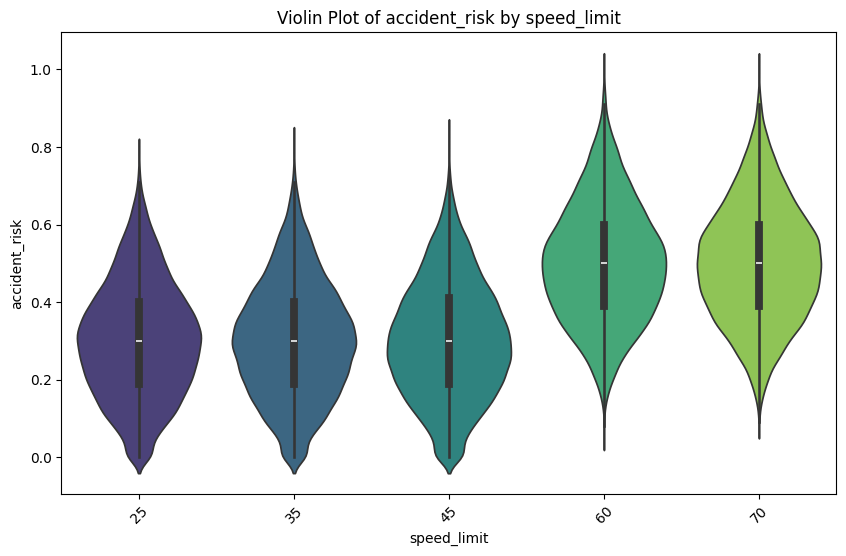

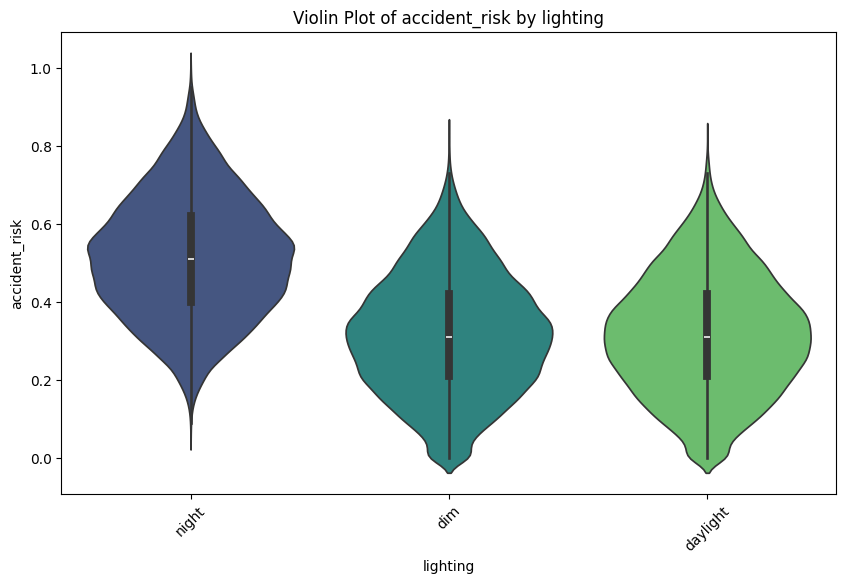

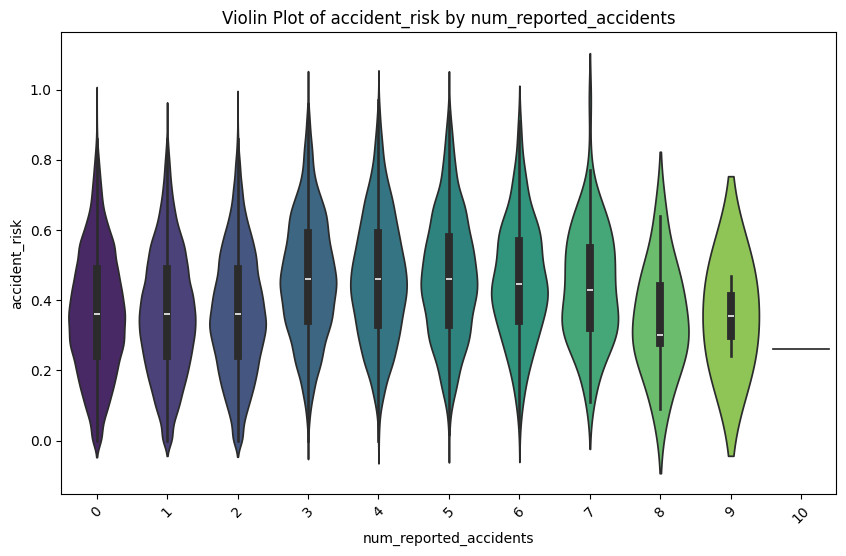

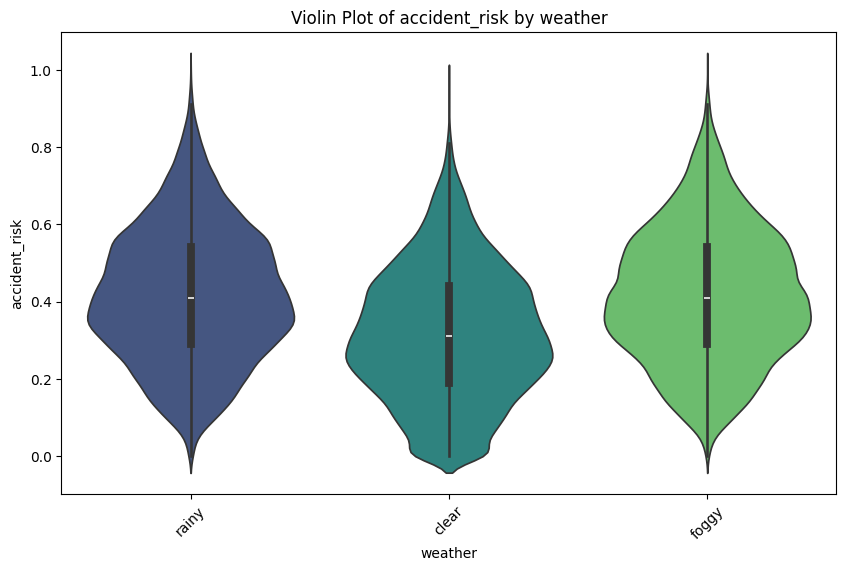

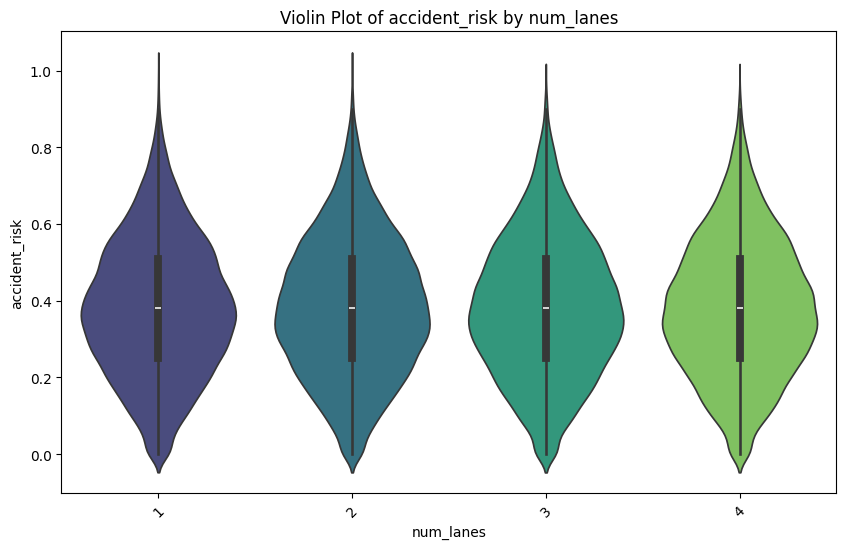

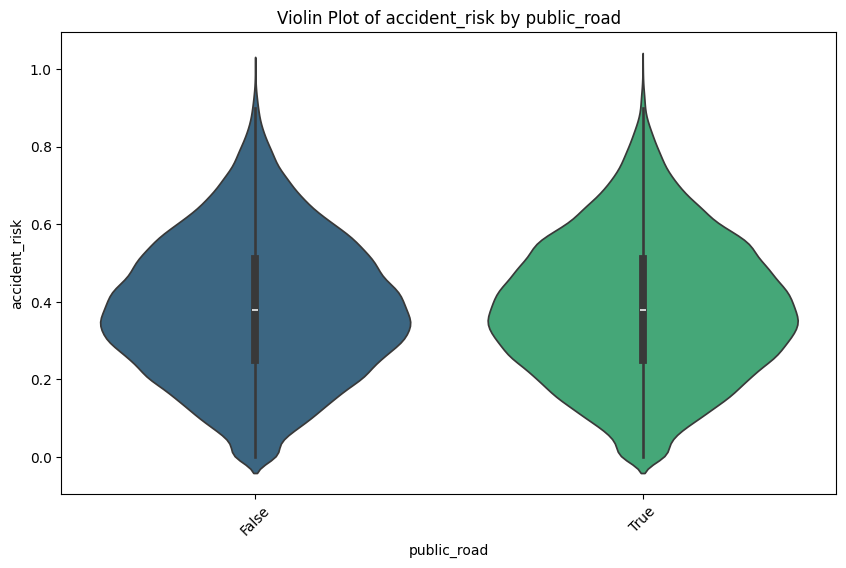

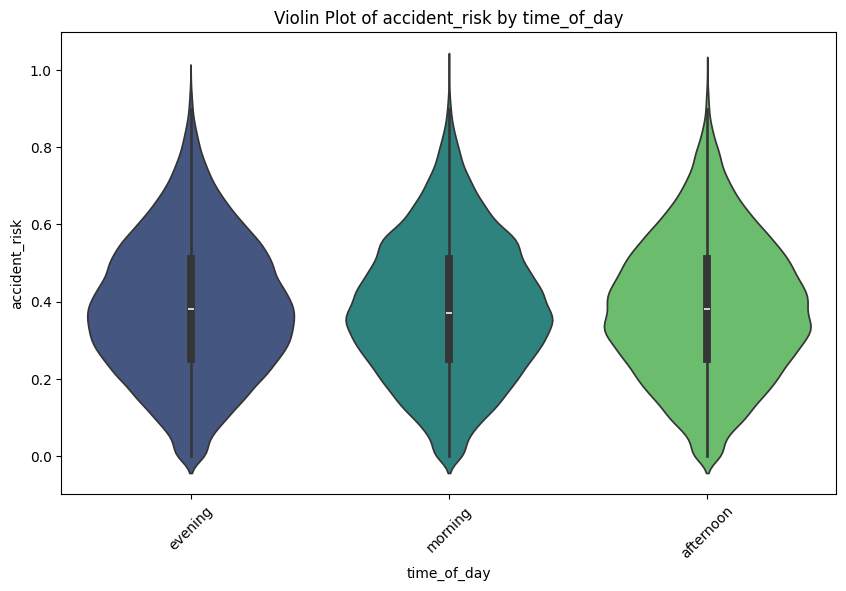

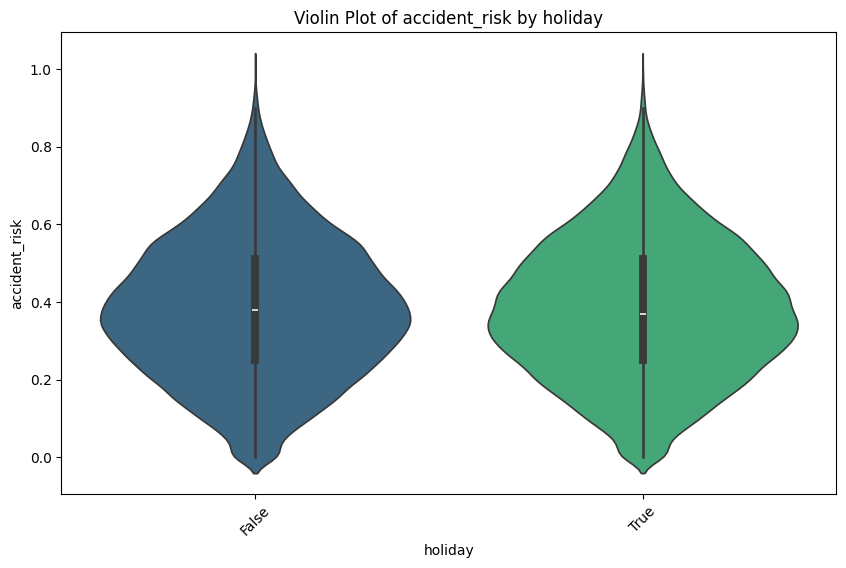

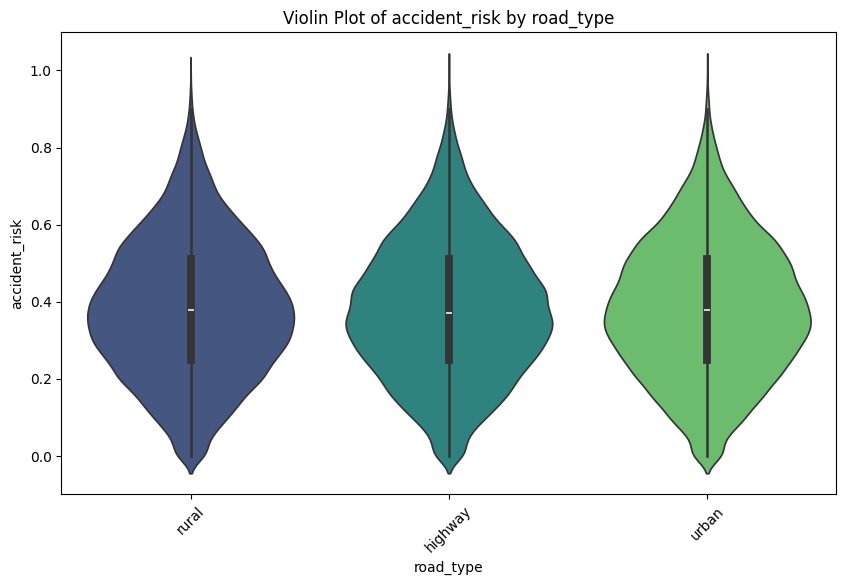

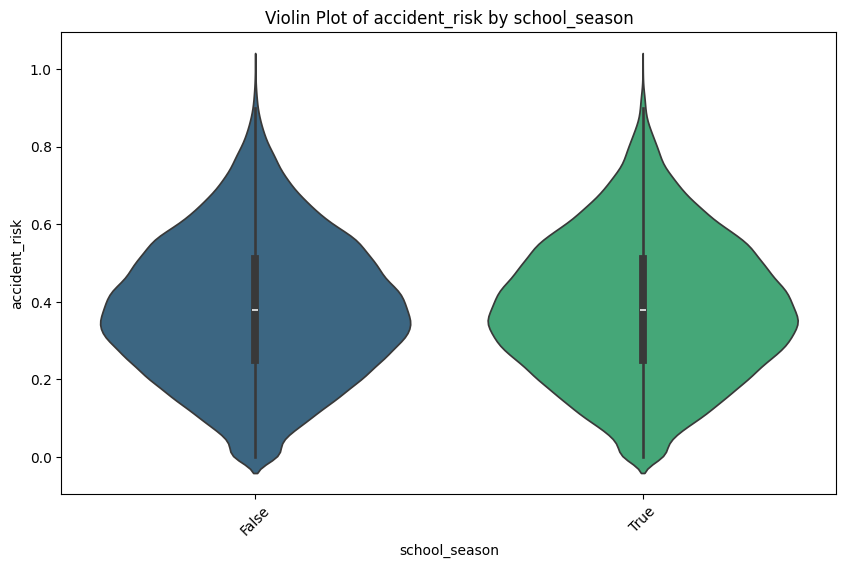

### Numeric × Categorical (Trend By Category)

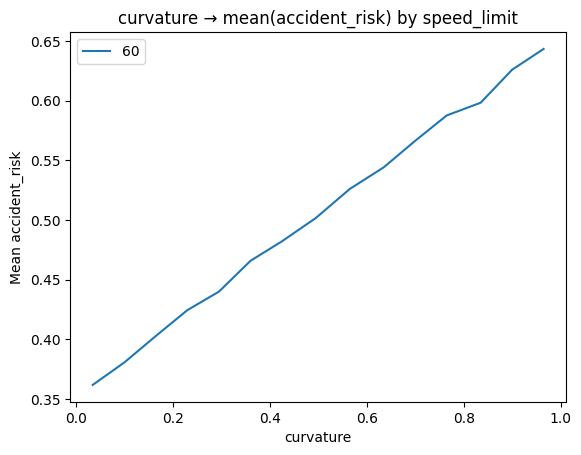

### Categorical × Categorical (Heatmap)

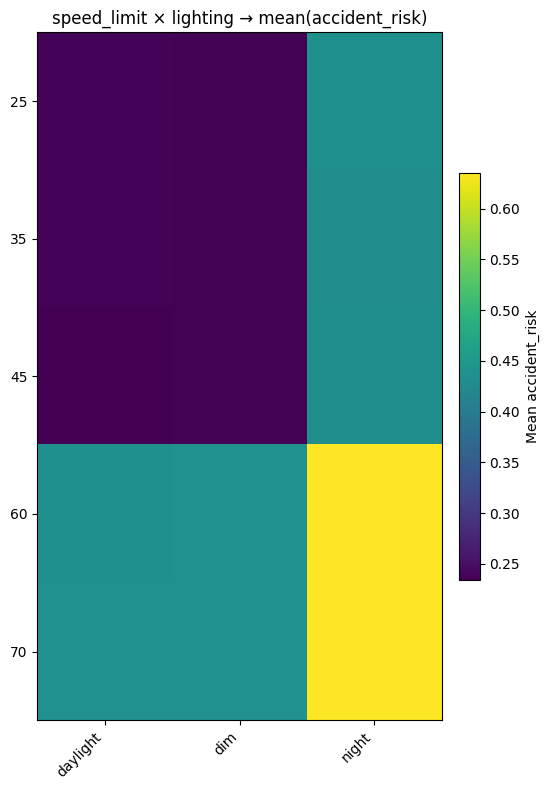

### Time of Day vs Risk Line

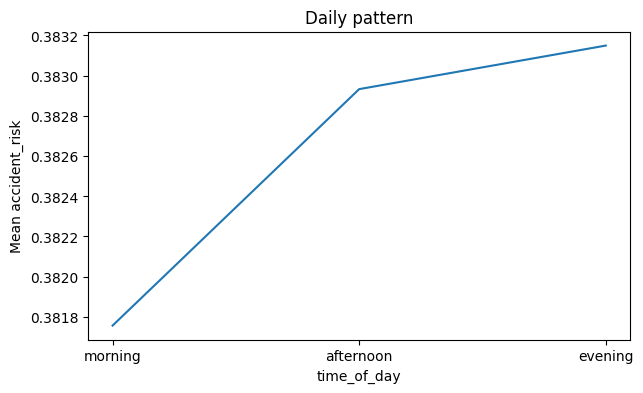

### Feature Signal Ranking

Top numeric (|Spearman|): [('speed_limit', 0.4755381706437699), ('curvature', 0.4694321426363731), ('num_reported_accidents', 0.14849663923552892), ('num_lanes', 0.0015855889200950967)]
Top categorical (range of mean risk): [('lighting', 0.197170074415491, 3), ('weather', 0.09975717725890859, 3), ('public_road', 0.0016333563844195265, 2), ('time_of_day', 0.001393338501637309, 3), ('holiday', 0.0013072121613361132, 2), ('road_type', 0.0007169961157473814, 3), ('school_season', 0.0005527101733853179, 2), ('road_signs_present', 0.00016134600929357257, 2)]


In [39]:
run_eda(original_df, target=TARGET, max_cat_card=30)

### Feature distributions

## Dataset Comparison Report

The exploratory data analysis reveals that the training and test datasets are remarkably similar, which is excellent for building a generalizable model. Here's a breakdown of the comparison:

*   **Data Structure and Quality**:
    
    *   Both datasets are clean with **no missing values**.
        
    *   The column types and feature names are consistent between the two sets (with the obvious exception of the accident\_risk target variable in the test set).
        
    *   Both datasets contain a small number of **duplicate rows** (656 in training, 1203 in testing). The training dupes might need to be removed before training to prevent any data leakage or bias.
        
*   **Feature Distributions**:
    
    *   **Numerical Features**: The distributions of curvature, speed\_limit, num\_lanes, and num\_reported\_accidents are nearly identical across both the training and test sets. The summary statistics (mean, std, min, max, etc.) are also very closely aligned. This indicates that the test set is a representative sample of the training data.
        
    *   **Categorical Features**: The value counts for categorical features like road\_type, lighting, weather, and time\_of\_day show very similar proportions in both datasets. There is no significant drift in the categorical distributions, which is favorable for model training.
        
    *   **Boolean Features**: Similarly, the boolean features (road\_signs\_present, public\_road, holiday, school\_season) have comparable distributions of True and False values.
        
*   **Correlations and Relationships**:
    
    *   The correlation matrices for the numerical features in both datasets are very similar. The relationships between features like curvature, speed\_limit, and num\_reported\_accidents are consistent.
        
    *   The box plots, violin plots, and pair plots on the training data reveal clear relationships between several features and the accident\_risk. Since the feature distributions are so similar in the test set, we can infer that these relationships will likely hold, which is a positive indicator for the model's predictive power.
        

In summary, the high degree of similarity between the training and test datasets suggests that a model trained on this data should perform well on the unseen test data without needing complex adjustments for distribution shifts

## Feature Engineering

Based on the EDA, here are some suggested next steps for feature engineering to enhance a model's performance:

1.  **Handle Categorical Features**:
    
    *   The categorical features (road\_type, lighting, weather, time\_of\_day) have low cardinality. **One-hot encoding** is a suitable approach here.
        
2.  **Create Interaction Features**:
    
    *   The EDA shows that curvature and speed\_limit are the two features most strongly correlated with accident\_risk. It's highly likely that their interaction is also significant.
        
    *   Consider other potentially meaningful interactions, especially between numerical and categorical features. For example, the effect of curvature might be different on a highway versus a rural road.
        
3.  **Polynomial Features**:
    
    *   Since curvature and speed\_limit show strong, somewhat linear relationships with the target, we should explore creating polynomial features from them to capture any non-linear effects. sklearn.preprocessing.PolynomialFeatures is a good tool for this.
        
4.  **Address the Leaky Feature**:
    
    *   The num\_reported\_accidents feature is a potential source of data leakage, as it's correlated with the target. While it's not a perfect predictor (meaning it's "leaky" rather than a direct spoiler), we should use it with caution. Here are a couple of strategies:
        
        *   **Drop the feature**: The simplest approach is to remove it entirely to avoid any risk of leakage.
            
        *   **Feature Engineering**: Create aggregate features from it. For example, we could calculate the average accident\_risk per num\_reported\_accidents in the training set and then use this as a new feature. Be careful to do this in a way that doesn't leak target information during cross-validation.
            
5.  **Binning Numerical Features**:
    
    *   While the relationships appear fairly linear, we could experiment with binning some of the numerical features, like speed\_limit, into categories (e.g., 'low', 'medium', 'high'). This can sometimes help tree-based models identify more distinct patterns.
        
6.  **Time-Based Features**:
    
    *   The time\_of\_day feature is categorical, but we could also treat it as an ordered feature. Given the daily pattern observed in the "Time of Day vs Risk" plot, we could encode it numerically (e.g., morning=1, afternoon=2, evening=3) to see if that captures the trend better for some models.

## Model Training

In [40]:
# Model Training

#TBD

## Prepare Submission

In [41]:
# Build submission

# TODO